In [1]:
import numpy as np
import pandas as pd
import pylab
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.signal import lfilter
from statistics import *
from itertools import groupby

In [3]:
import csv

filePath = 'SRR1552480_MDS.csv'
dataRows = []

with open(filePath) as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in readCSV:
        if i > 0:
            dataRows.append(list(map(float, row[1:])))
        i += 1

In [4]:
def peakPreProc(rowNum):
    dataRow_tmp0 = dataRows[rowNum]
    def chunks1(lst, n):
        """Yield successive n-sized chunks from lst."""
        for i in range(0, len(lst), n):
            yield lst[i:i + n]
    def chunks2(lst, n):
        """rolling cluster buckets"""
        for i in range(0, len(lst) - n, 1):
            yield lst[i:i + n]
    
    dataRow = []
    dataRow_tmp1 = []
    dataRow_tmp2 = []
    
    #break data into buckets of 5 units each
    #[[0,5], [6, 10], [11,15], ...]
    #get the sum of each bucket
    #generate new dataset with bucketed data
    #this allows us to eccentuate peak data and create larger gaps between signal and noise
    for i in chunks1(dataRow_tmp0, 10):
        dataRow_tmp1.append(sum(i))
        
    #generate rolling buckets
    #[[0,n], [1,n+1], [2, n+2], ...]
    #get the mean of each subbucket
    #this smooths out noisy peaks and imporoves detection rates
    #this lets us filter out 1 unit wide 'peaks' in the middle of noise
    #this also makes real peaks easier to detect by smoothing out 'twin tower' peaks
    for i in chunks2(dataRow_tmp1, 10):
        dataRow.append(mean(i))
        
    #alternative filter
    #does not work well
    #https://stackoverflow.com/questions/37598986/reducing-noise-on-data
    #dataRow = savgol_filter(dataRow_tmp1, 11, 2)
        
    #alternative filter
    #does not work well
    #https://stackoverflow.com/questions/37598986/reducing-noise-on-data
    #n = 15  # the larger n is, the smoother curve will be
    #b = [1.0 / n] * n
    #a = 1
    #dataRow = lfilter(b,a,y)
        
    return dataRow

Peak detection tool from https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/43512887#43512887

Peak signal detection in realtime timeseries data 
https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/22640362#22640362

designed for time-series/realtime signal analysis

does not work well for our data.  peaks are too slow, noise spikes are too big

In [5]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

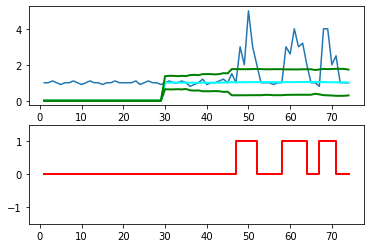

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
       1., 1., 1., 0., 0., 0.])

In [6]:
# Data
y = np.array([1,1,1.1,1,0.9,1,1,1.1,1,0.9,1,1.1,1,1,0.9,1,1,1.1,1,1,1,1,1.1,0.9,1,1.1,1,1,0.9,
       1,1.1,1,1,1.1,1,0.8,0.9,1,1.2,0.9,1,1,1.1,1.2,1,1.5,1,3,2,5,3,2,1,1,1,0.9,1,1,3,
       2.6,4,3,3.2,2,1,1,0.8,4,4,2,2.5,1,1,1])

# Settings: lag = 30, threshold = 5, influence = 0
lag = 30
threshold = 6
influence = 0.01

# Run algo with settings from above
result = thresholding_algo(y, lag=lag, threshold=threshold, influence=influence)

# Plot result
pylab.subplot(211)
pylab.plot(np.arange(1, len(y)+1), y)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"], color="cyan", lw=2)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)

pylab.subplot(212)
pylab.step(np.arange(1, len(y)+1), result["signals"], color="red", lw=2)
pylab.ylim(-1.5, 1.5)
pylab.show()

display(result["signals"])

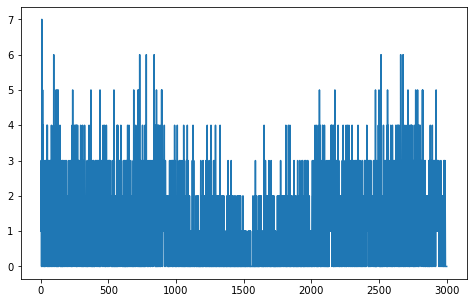

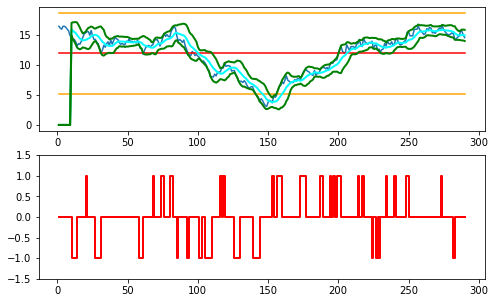

In [7]:
def realtimePeakFinder(rowNum):
    plt.rcParams["figure.figsize"] = (8,5)
    #print raw data
    dataRow = dataRows[rowNum]
    pylab.plot(np.arange(1, len(dataRow)+1), dataRow)
    pylab.show()
    #get processed data
    dataRow = peakPreProc(rowNum)
    y = np.array(dataRow)
    my = mean(y)
    sy = stdev(y)
    sy2 = sy * 2
    
    # Settings: lag = 30, threshold = 5, influence = 0
    lag = 10
    threshold = 2
    influence = 1
    result = thresholding_algo(y, lag=lag, threshold=threshold, influence=influence)

    # Plot result
    pylab.subplot(211)
    pylab.plot(np.arange(1, len(y)+1), y)
    pylab.plot(np.arange(1, len(y)+1), np.array([my] * (len(y))), color="red")
    pylab.plot(np.arange(1, len(y)+1), np.array([my] * (len(y))) + sy2, color="orange")
    pylab.plot(np.arange(1, len(y)+1), np.array([my] * (len(y))) - sy2, color="orange")

    pylab.plot(np.arange(1, len(y)+1),
               result["avgFilter"], color="cyan", lw=2)

    pylab.plot(np.arange(1, len(y)+1),
               result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)

    pylab.plot(np.arange(1, len(y)+1),
               result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)

    pylab.subplot(212)
    pylab.step(np.arange(1, len(y)+1), result["signals"], color="red", lw=2)
    pylab.ylim(-1.5, 1.5)
    pylab.show()
    
realtimePeakFinder(2)

https://stackoverflow.com/questions/1713335/peak-finding-algorithm-for-python-scipy

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

http://im.snibgo.com/histopeaks.htm

scikit peak finder. works better for our data

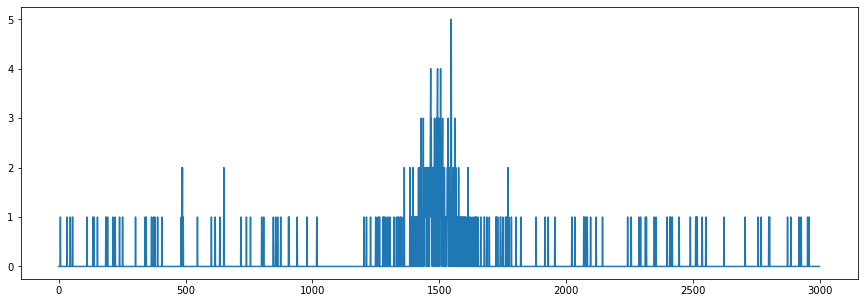

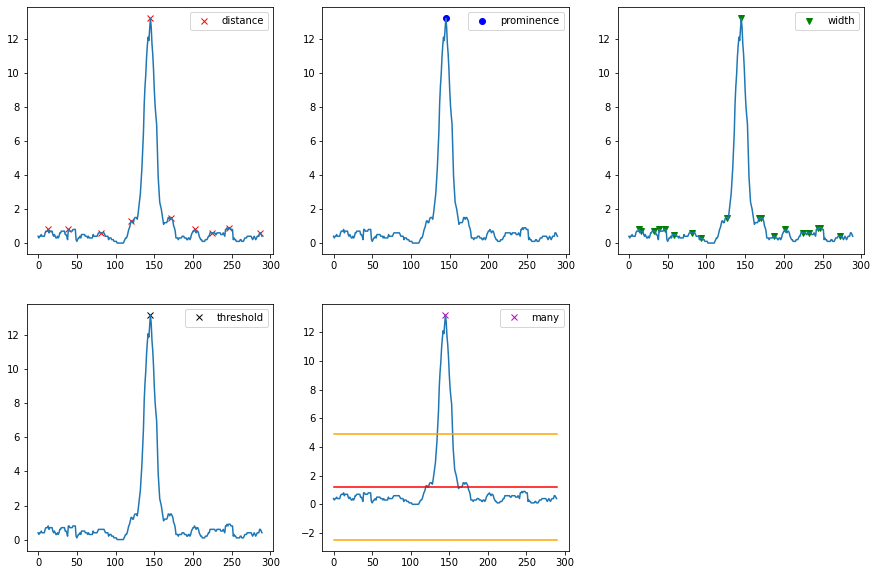

0
Peak(s):   1


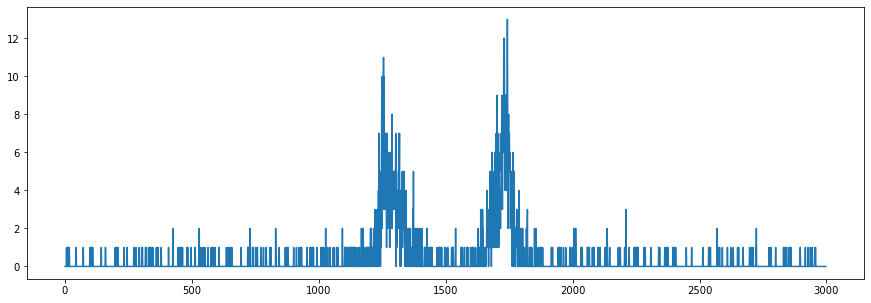

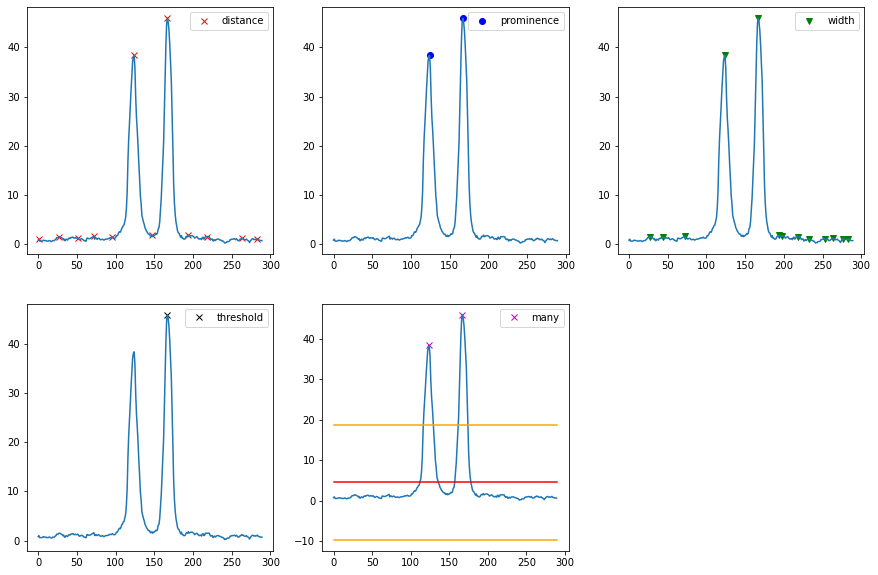

1
Peak(s):   2


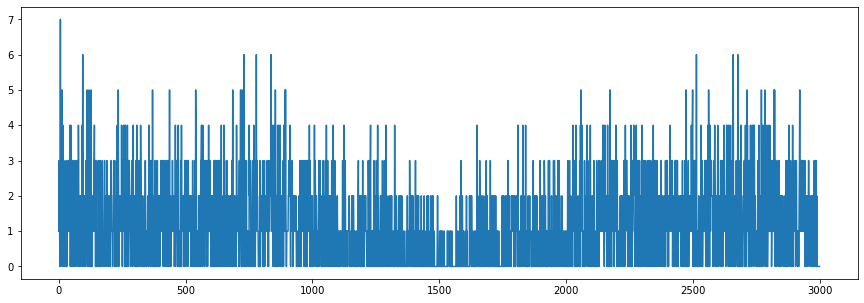

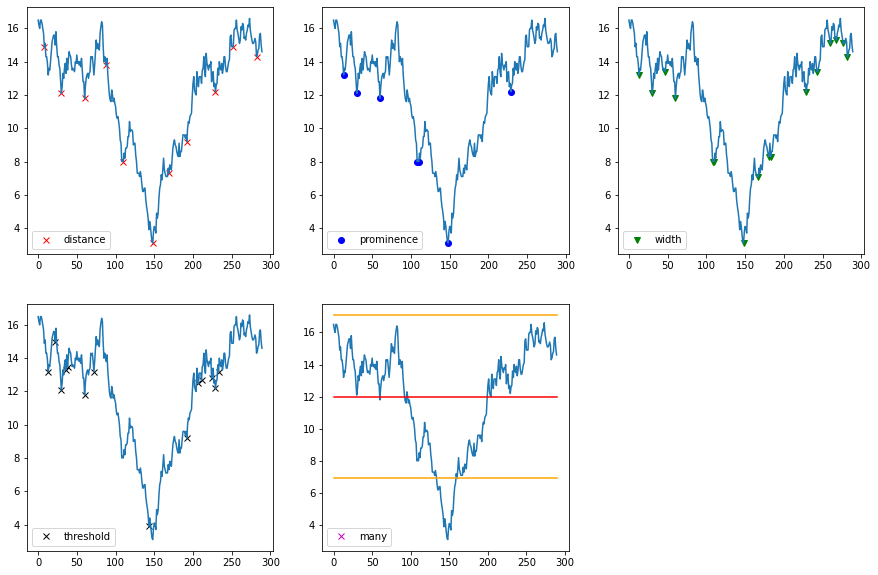

2
Trough(s):   0


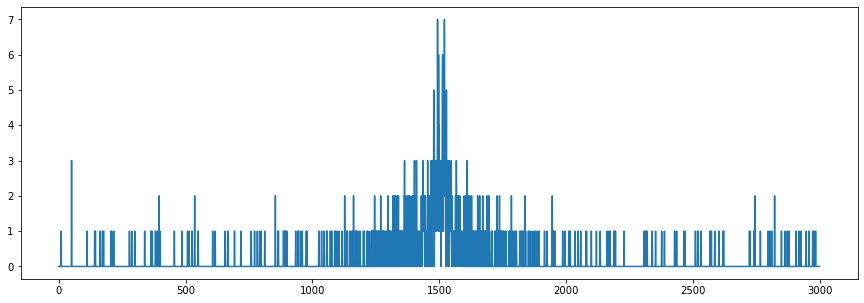

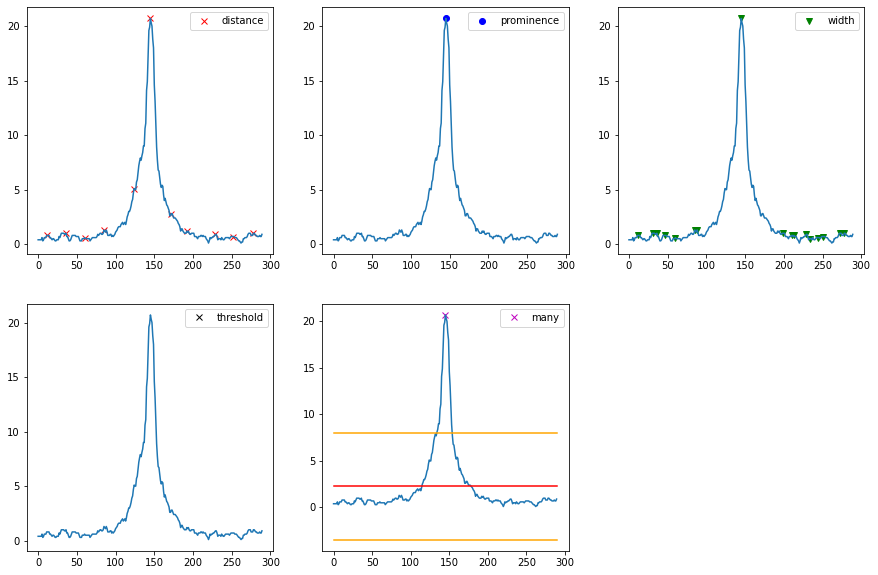

3
Peak(s):   1


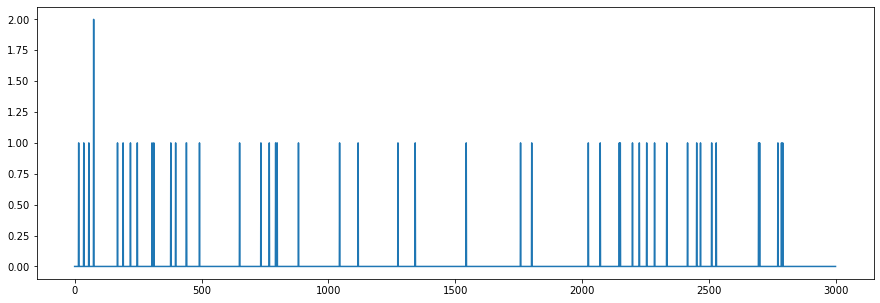

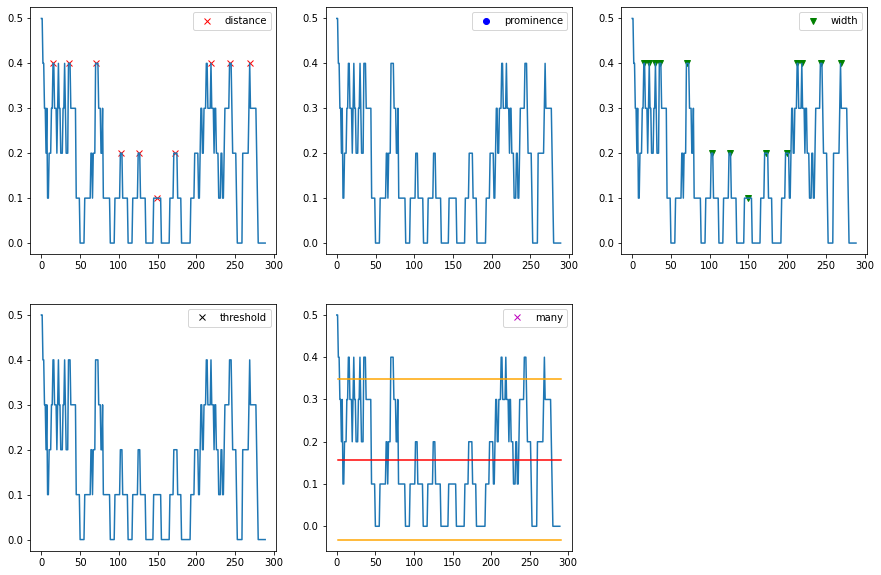

4
Peak(s):   0


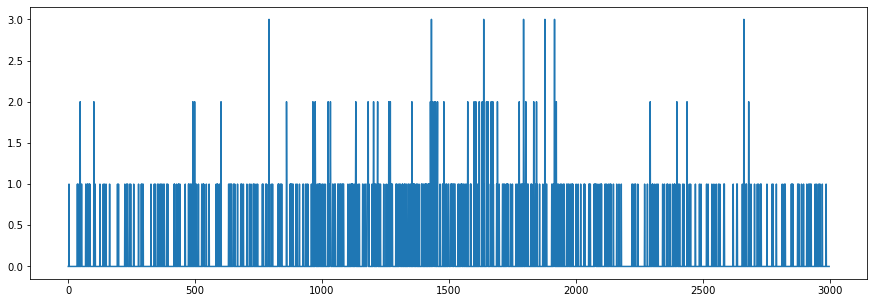

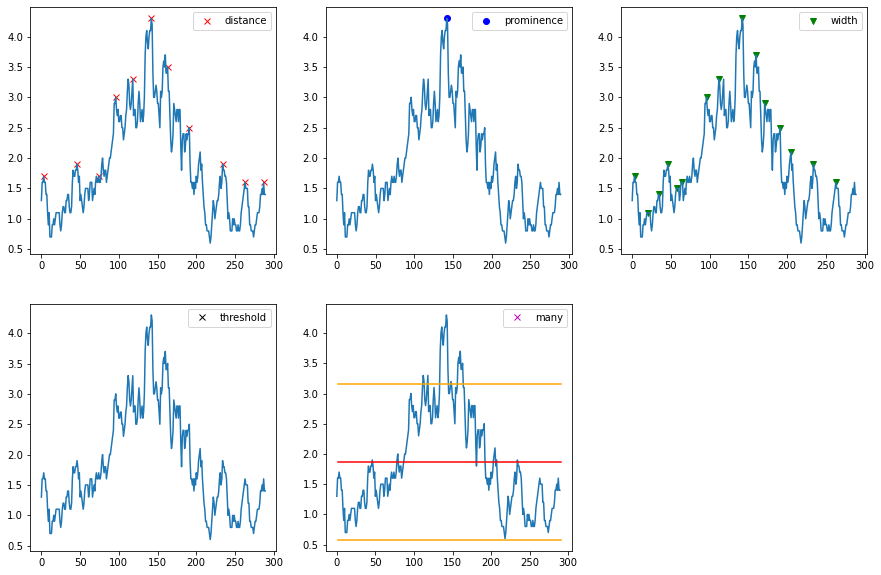

5
Peak(s):   0


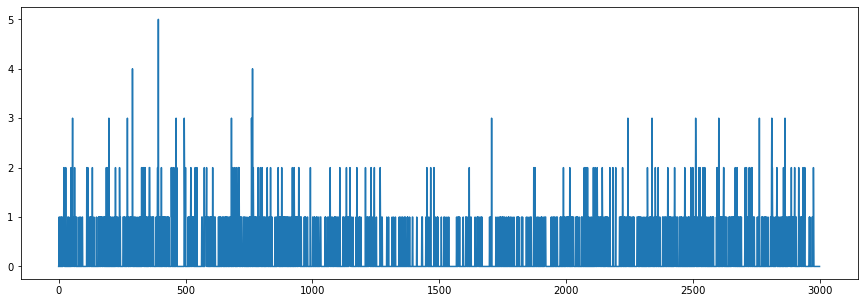

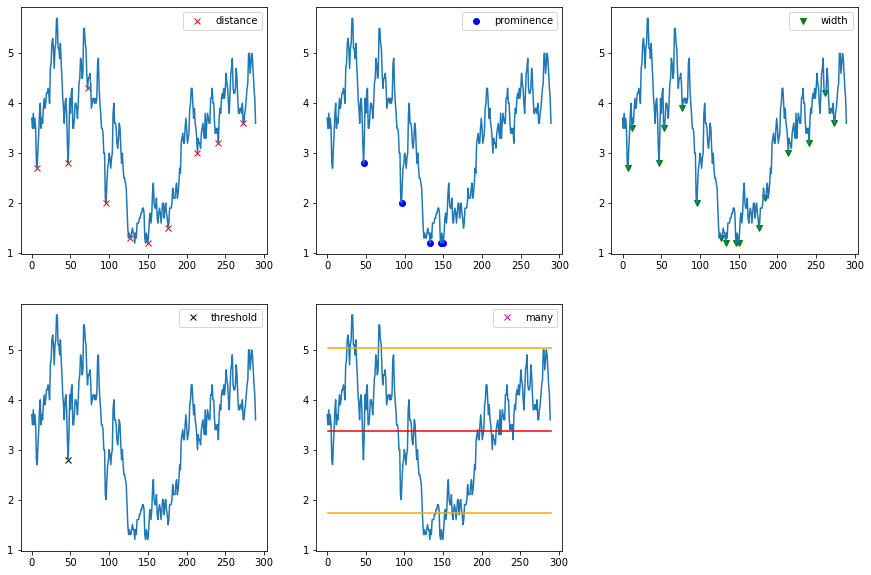

6
Trough(s):   0


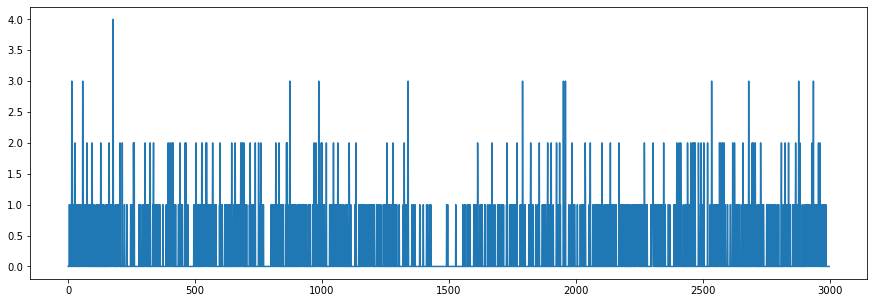

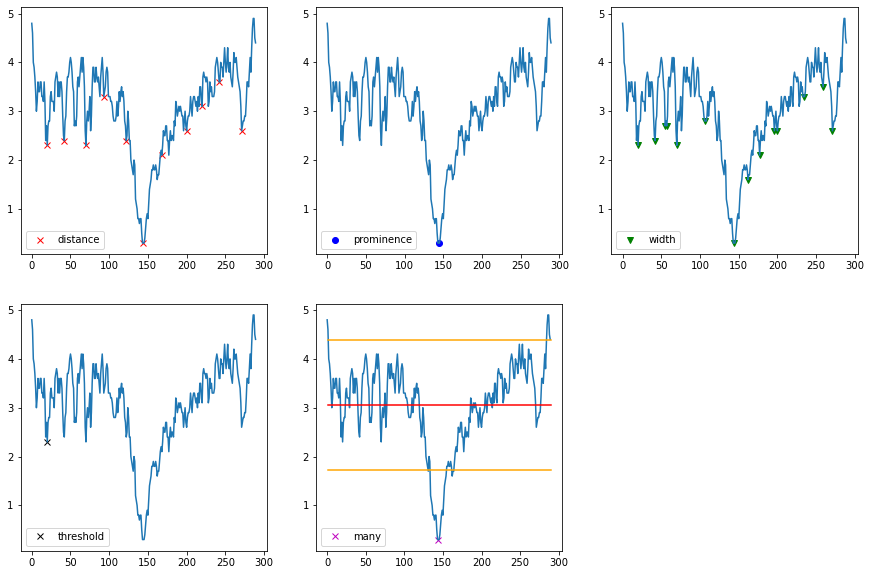

7
Trough(s):   1


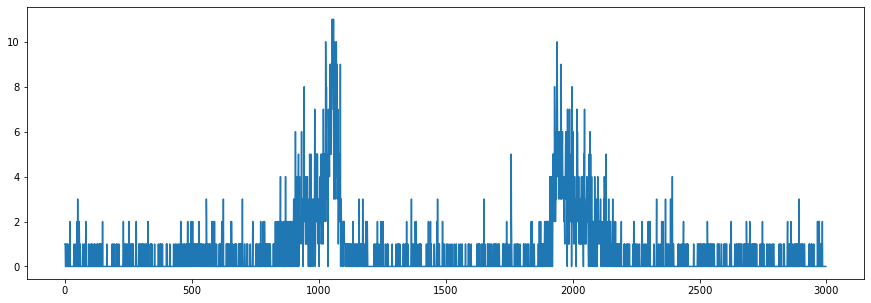

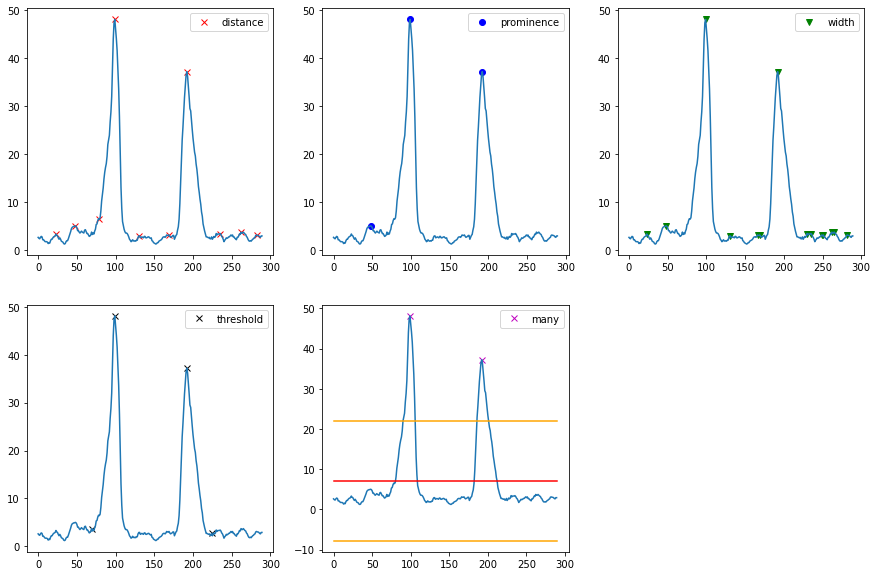

8
Peak(s):   2


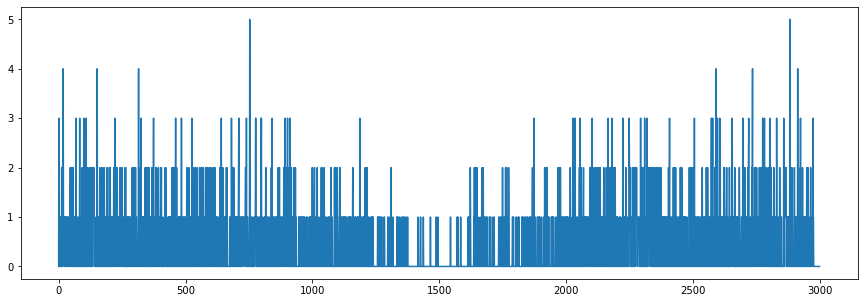

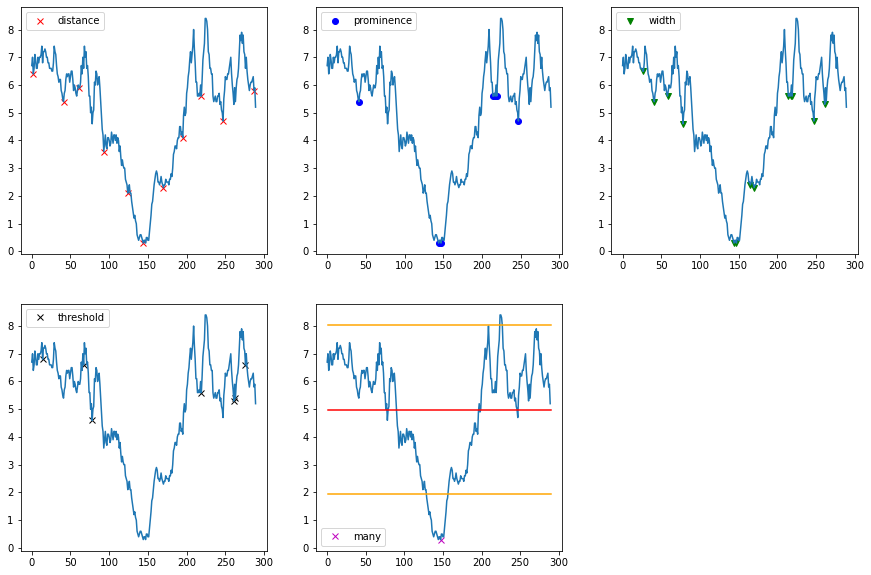

9
Trough(s):   1


In [8]:
rowNum = 0

def findExtremaVerbose(rowNum, dataRow, invert):
    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(np.array(dataRows[rowNum]))
    plt.show()
    
    ymax = max(dataRow)
    my = mean(dataRow)
    sy = stdev(dataRow)
    sy15 = sy * 1.5
    sy2 = sy * 2
    
    #invert data before finding peaks
    if invert == True:
        y = ymax - np.array(dataRow)
    else:
        y = np.array(dataRow)
    
    #returns indexes of y that are detected as peaks
    peakX = np.arange(1, len(y)+1)
    peaks, _ = find_peaks(y, distance=20)
    peaks2, _ = find_peaks(y, prominence=2)
    peaks3, _ = find_peaks(y, width=3)
    peaks4, _ = find_peaks(y, threshold=0.4)     # Required vertical distance to its direct neighbouring samples, pretty useless
    peaks5, _ = find_peaks(y, height=my+sy15, distance = 20, prominence=(4, None), width=3)
    
    #reinvert data after peak search for proper visual 
    if invert == True:
        y = (y * (-1)) + ymax    
    
    plt.rcParams["figure.figsize"] = (15,10)
    plt.subplot(2, 3, 1)
    plt.plot(peaks, y[peaks], "xr"); plt.plot(y); plt.legend(['distance'])
    plt.subplot(2, 3, 2)
    plt.plot(peaks2, y[peaks2], "ob"); plt.plot(y); plt.legend(['prominence'])
    plt.subplot(2, 3, 3)
    plt.plot(peaks3, y[peaks3], "vg"); plt.plot(y); plt.legend(['width'])
    plt.subplot(2, 3, 4)
    plt.plot(peaks4, y[peaks4], "xk"); plt.plot(y); plt.legend(['threshold'])
    plt.subplot(2, 3, 5)
    plt.plot(peaks5, y[peaks5], "xm"); plt.plot(y); plt.legend(['many'])
    plt.plot(peakX, np.array([my] * (len(y))), color="red")
    plt.plot(peakX, np.array([my] * (len(y))) + sy15, color="orange")
    plt.plot(peakX, np.array([my] * (len(y))) - sy15, color="orange")
    plt.show()
    
    return len(peaks5)
    
#find peaks in histo
def findPeaksVerbose(rowNum):
    dataRow = peakPreProc(rowNum)
    findExtremaVerbose(rowNum, dataRow, False)
    return "Peak(s):"
    
#find troughs by running the peak search algo on a inverted dataset
#uses max(y) - y
def findTroughsVerbose(rowNum):
    dataRow = peakPreProc(rowNum)
    findExtremaVerbose(rowNum, dataRow, True)
    return "Trough(s):"
    
#dynamically switch between peak/trough detection
#uses stddev outlier detection to determine if there is a substantial negative peak
#if n points are less than mean(y) - stddev(y), then the histo will be treated asna trough
def findDynamicExtremaVerbose(rowNum):
    dataRow = peakPreProc(rowNum)
    my = mean(dataRow)
    sy = stdev(dataRow)
    sy15 = sy * 1.5
    sy2 = sy * 2
    
    label = "Peak(s):"
    shouldInvert = False
    underThresh = 5
    underCount = 0
    for i in dataRow:
        if i < (my - sy15):
            underCount += 1
    if underCount >= underThresh:
        shouldInvert = True
        label = "Trough(s):"
    
    extCount = findExtremaVerbose(rowNum, dataRow, shouldInvert)
    return label, extCount
    
for i in range(0, 10):
    #findPeaks(i)
    #findTroughs(i)
    label, exCount = findDynamicExtremaVerbose(i)
    print(i)
    print(label, " ", exCount)


https://stackoverflow.com/a/6352456
groupby func

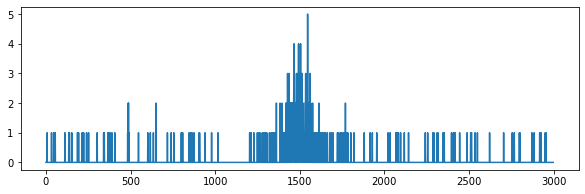

2.4630700105002497   3.6946050157503745


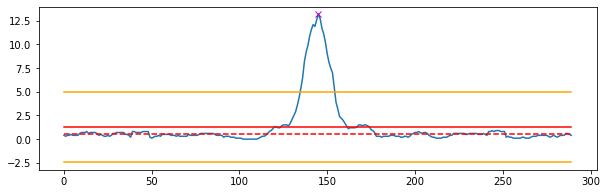

0
Peaks:  1   |  Troughs:  0


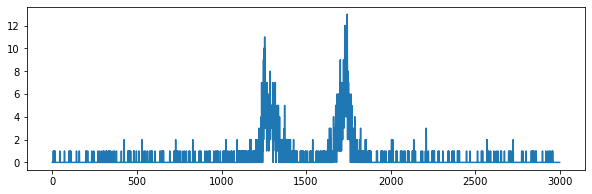

9.43353202931673   14.150298043975095


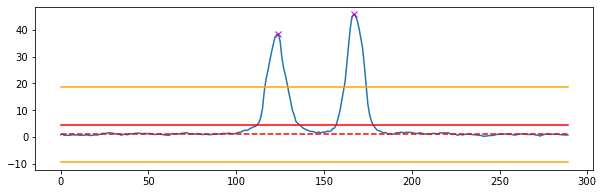

1
Peaks:  2   |  Troughs:  0


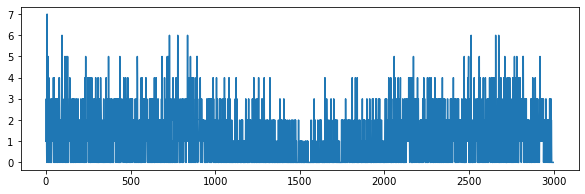

3.390556398030176   5.085834597045264


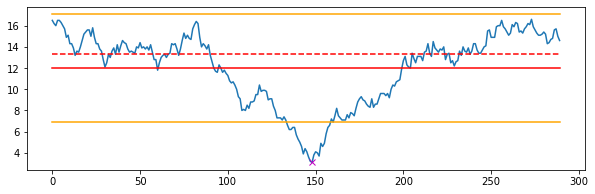

2
Peaks:  0   |  Troughs:  1


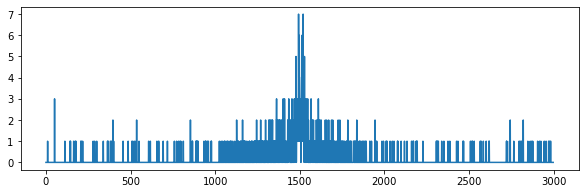

3.8166561564647905   5.724984234697185


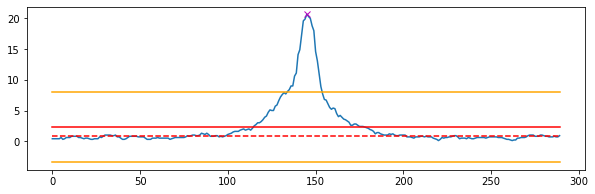

3
Peaks:  1   |  Troughs:  0


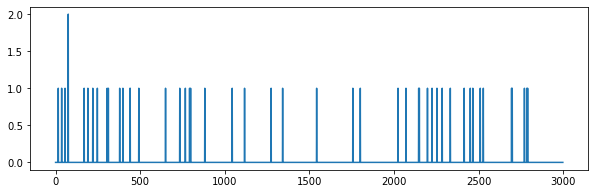

0.1262550642471861   0.18938259637077914


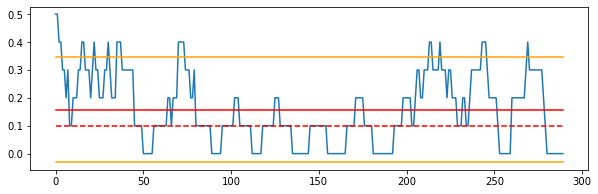

4
Peaks:  0   |  Troughs:  0


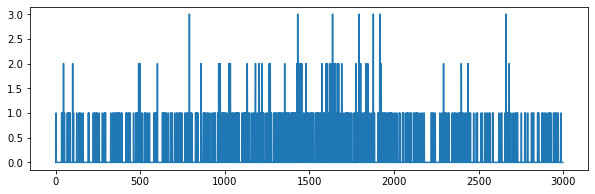

0.8584859293663105   1.2877288940494658


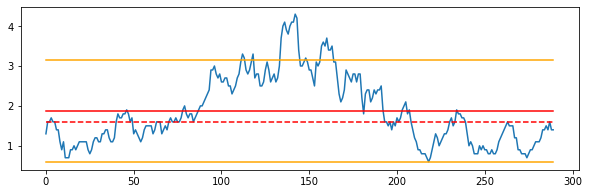

5
Peaks:  0   |  Troughs:  0


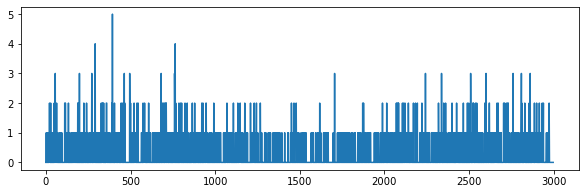

1.103105139942395   1.6546577099135926


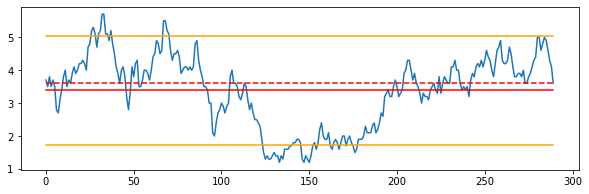

6
Peaks:  0   |  Troughs:  0


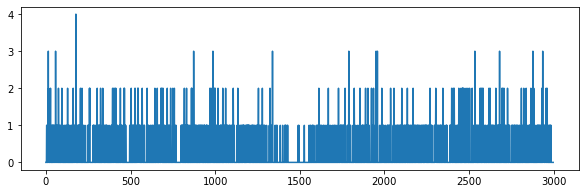

0.8850863004347526   1.327629450652129


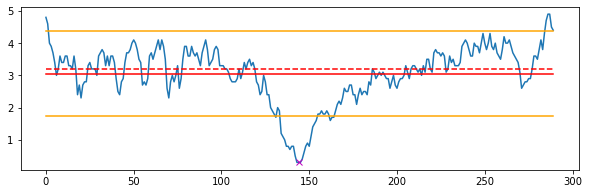

7
Peaks:  0   |  Troughs:  1


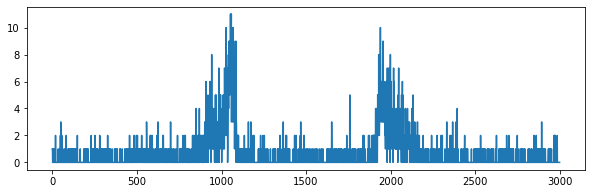

9.938076745879558   14.907115118819338


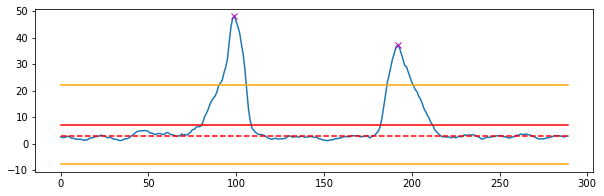

8
Peaks:  2   |  Troughs:  0


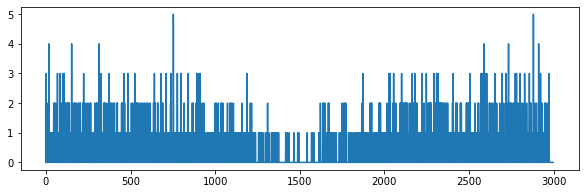

2.0401037100098005   3.0601555650147008


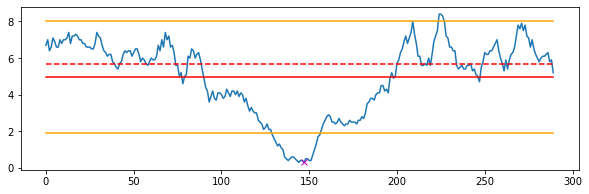

9
Peaks:  0   |  Troughs:  1


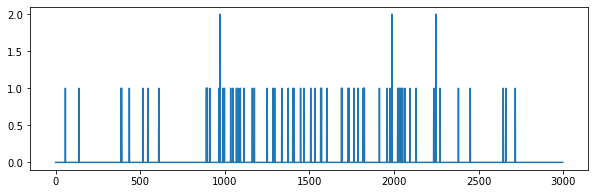

0.21855902354389653   0.3278385353158448


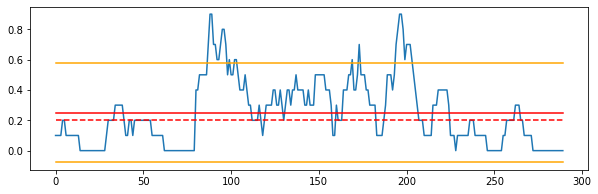

10
Peaks:  0   |  Troughs:  0


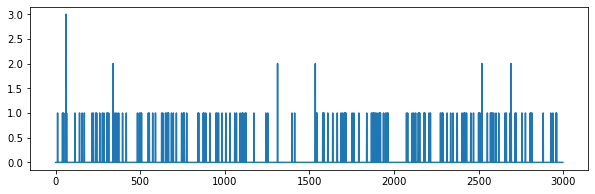

0.2608129334039247   0.39121940010588707


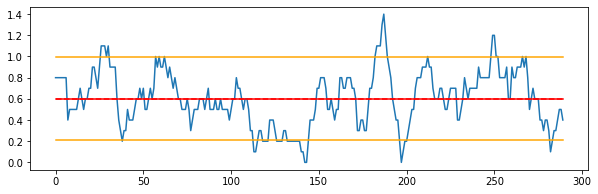

11
Peaks:  0   |  Troughs:  0


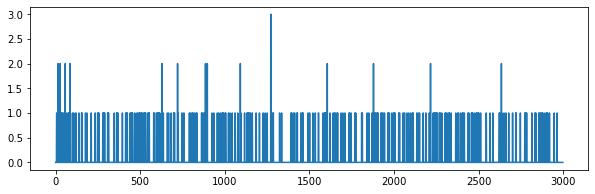

0.29809801562242727   0.4471470234336409


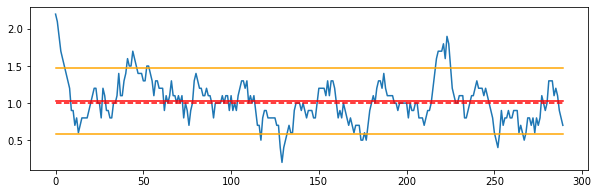

12
Peaks:  0   |  Troughs:  0


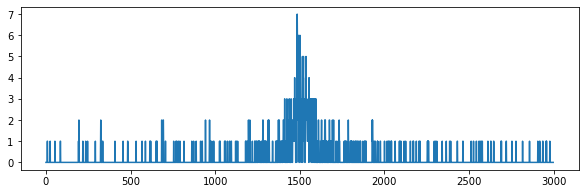

4.025091627018481   6.037637440527722


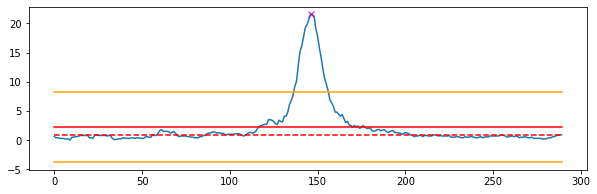

13
Peaks:  1   |  Troughs:  0


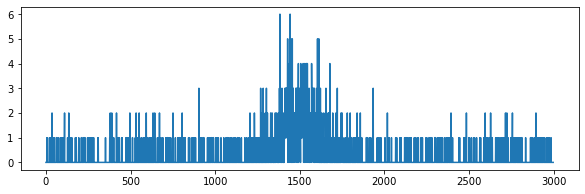

4.116249675957669   6.174374513936504


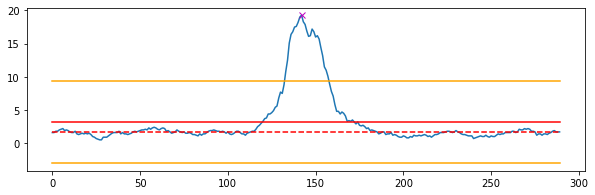

14
Peaks:  1   |  Troughs:  0


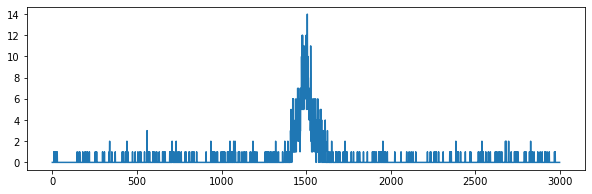

10.708735348628844   16.063103022943267


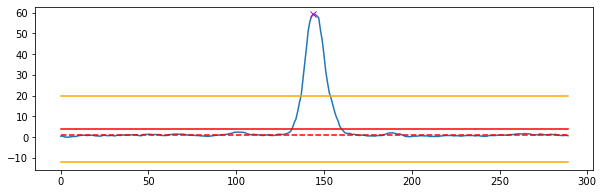

15
Peaks:  1   |  Troughs:  0


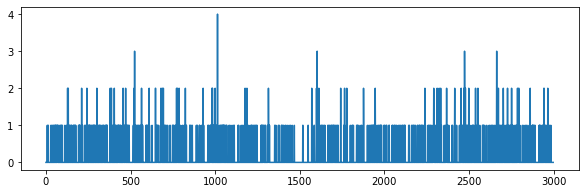

0.579528360093556   0.869292540140334


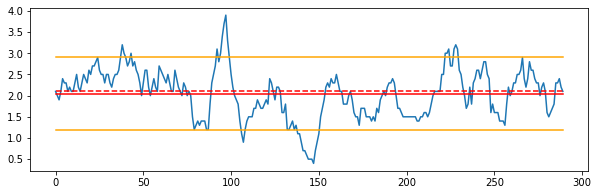

16
Peaks:  0   |  Troughs:  0


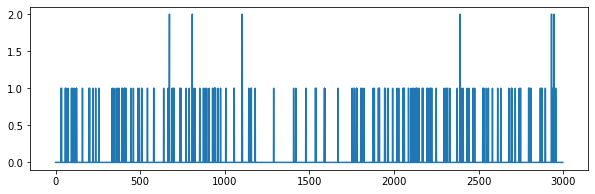

0.25555958753311886   0.38333938129967826


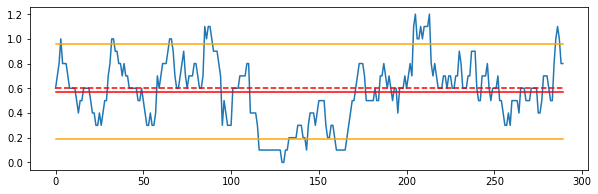

17
Peaks:  0   |  Troughs:  0


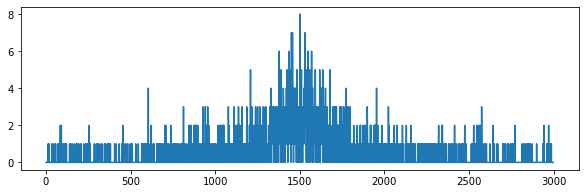

5.838623502198917   8.757935253298376


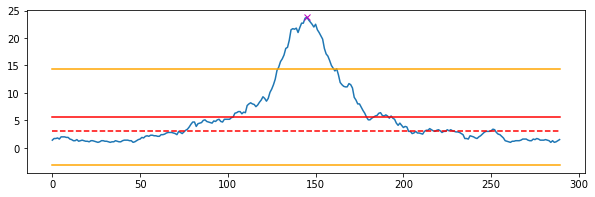

18
Peaks:  1   |  Troughs:  0


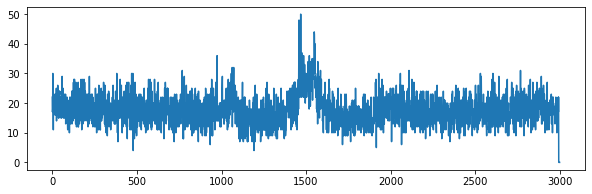

24.473207068479617   36.70981060271943


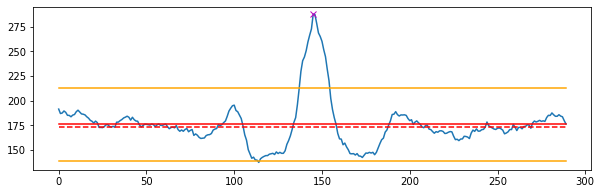

19
Peaks:  1   |  Troughs:  0


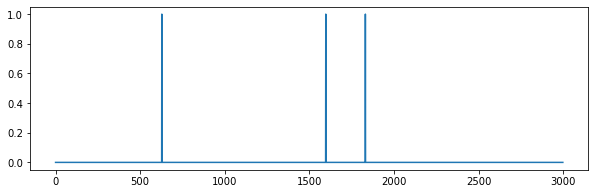

0.030506991497802394   0.04576048724670359


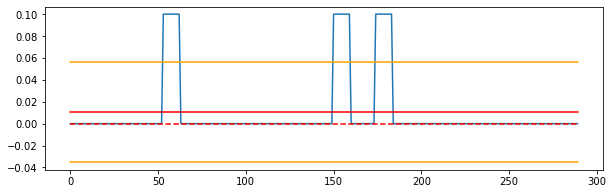

20
Peaks:  0   |  Troughs:  0


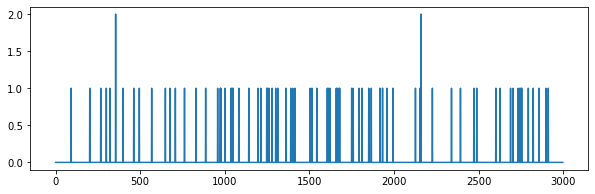

0.15769488542181542   0.23654232813272313


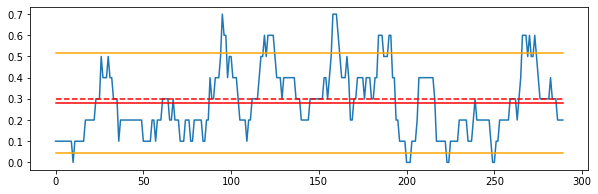

21
Peaks:  0   |  Troughs:  0


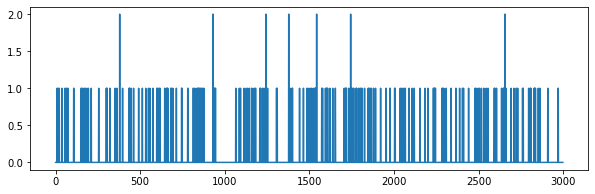

0.25890396131773646   0.3883559419766047


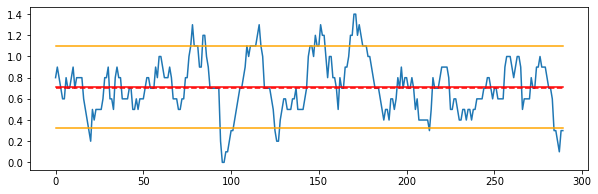

22
Peaks:  0   |  Troughs:  0


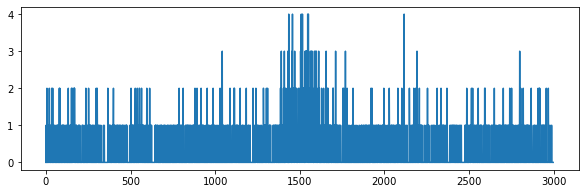

2.1768791075410197   3.2653186613115297


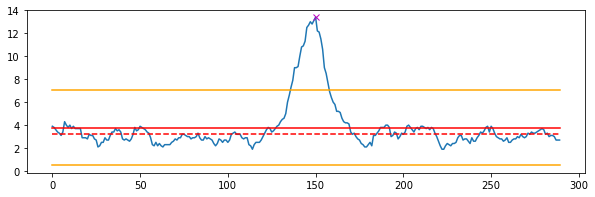

23
Peaks:  1   |  Troughs:  0


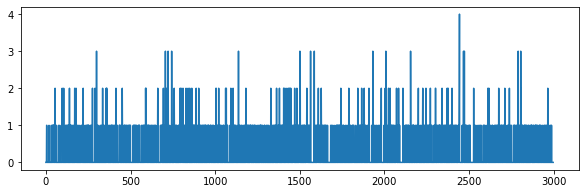

0.5905487974031495   0.8858231961047243


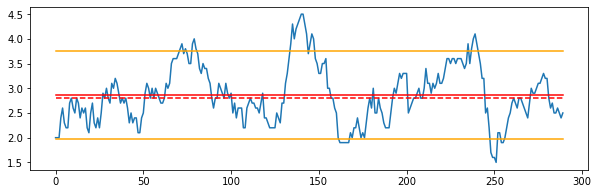

24
Peaks:  0   |  Troughs:  0


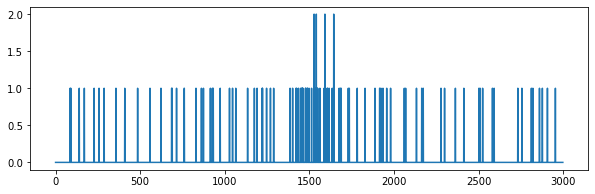

0.3406332669470324   0.5109499004205486


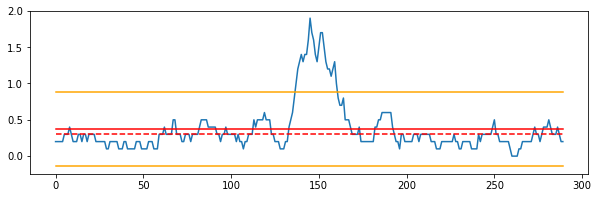

25
Peaks:  0   |  Troughs:  0


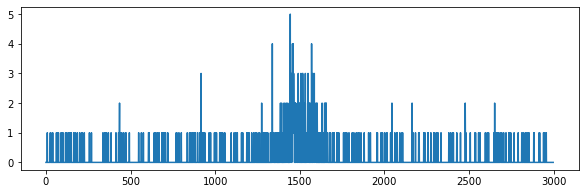

2.2586991017538067   3.38804865263071


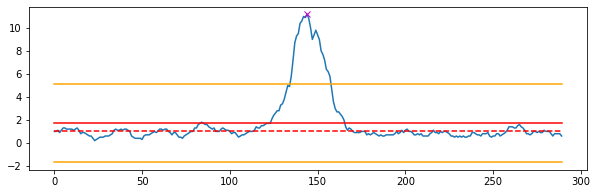

26
Peaks:  1   |  Troughs:  0


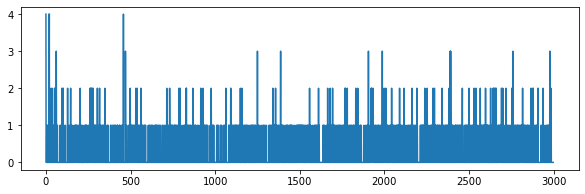

0.5197518521656412   0.7796277782484619


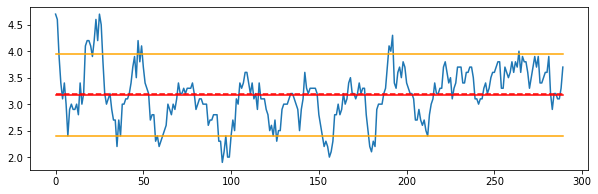

27
Peaks:  0   |  Troughs:  0


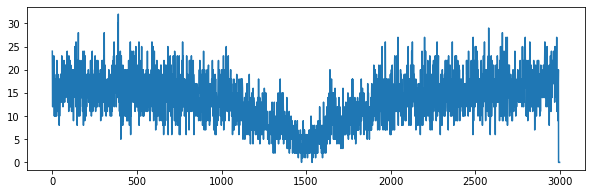

35.05492491119856   52.582387366797846


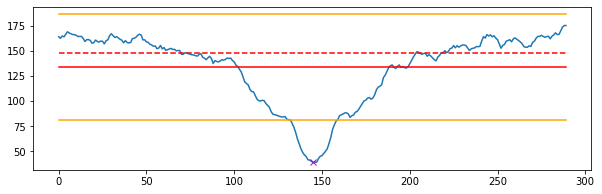

28
Peaks:  0   |  Troughs:  1


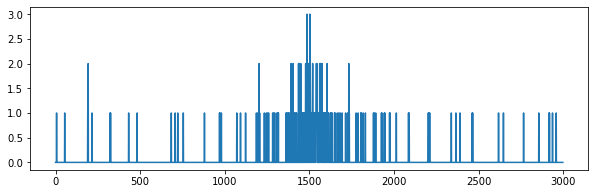

1.2303581962239256   1.8455372943358883


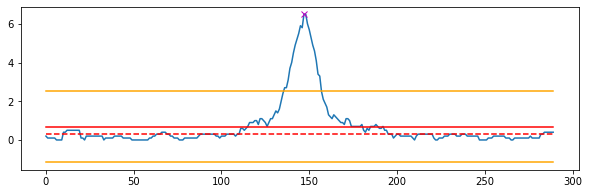

29
Peaks:  1   |  Troughs:  0


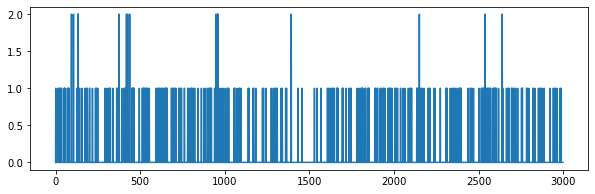

0.39182083304364496   0.5877312495654674


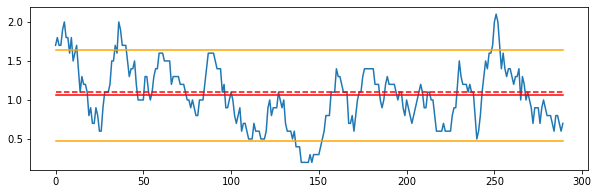

30
Peaks:  0   |  Troughs:  0


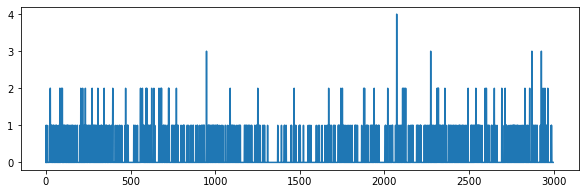

0.6844345565590231   1.0266518348385345


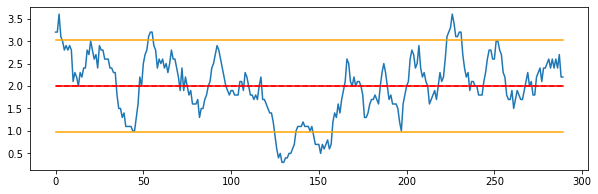

31
Peaks:  0   |  Troughs:  0


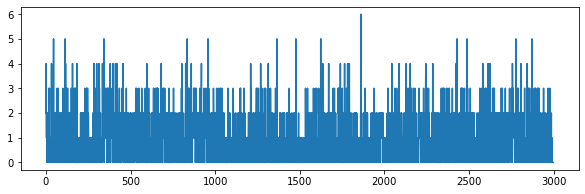

1.596931679405447   2.3953975191081702


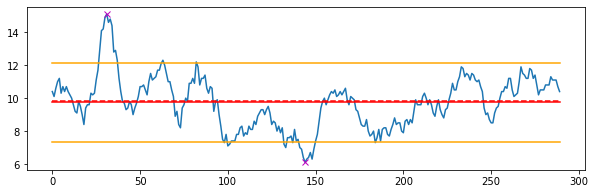

32
Peaks:  1   |  Troughs:  1


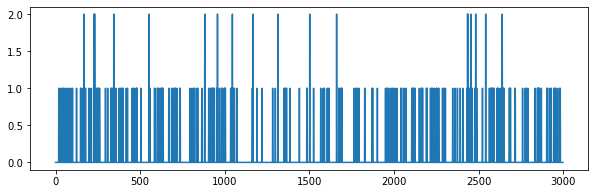

0.37571933155995985   0.5635789973399398


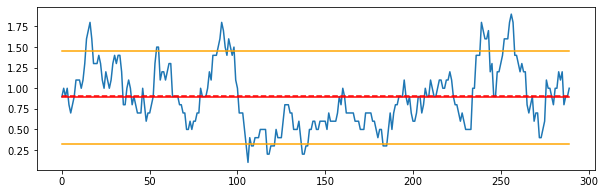

33
Peaks:  0   |  Troughs:  0


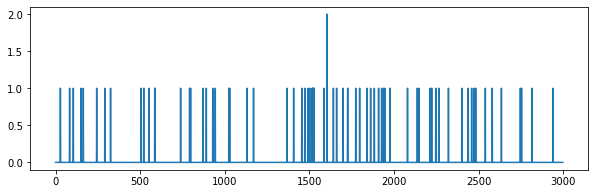

0.17294655784979254   0.25941983677468883


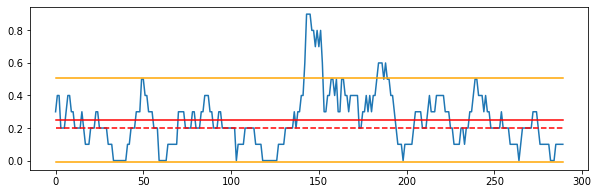

34
Peaks:  0   |  Troughs:  0


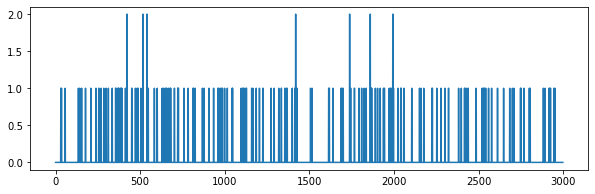

0.24809619936212451   0.3721442990431868


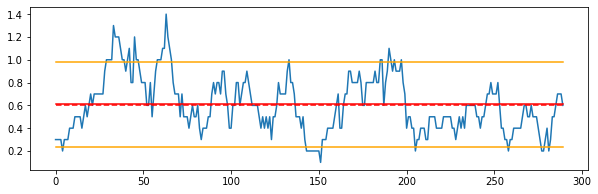

35
Peaks:  0   |  Troughs:  0


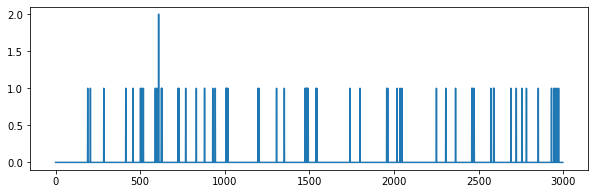

0.16812589529473232   0.2521888429420985


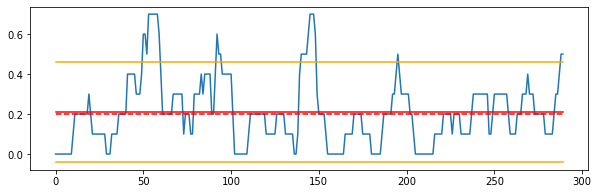

36
Peaks:  0   |  Troughs:  0


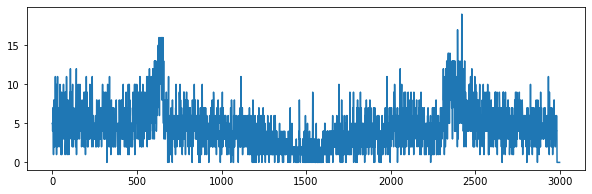

15.618841189264138   23.428261783896208


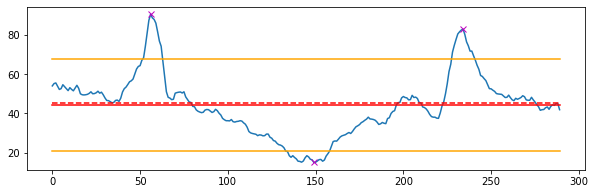

37
Peaks:  2   |  Troughs:  1


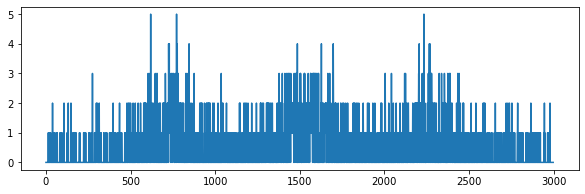

3.1338712335137258   4.700806850270588


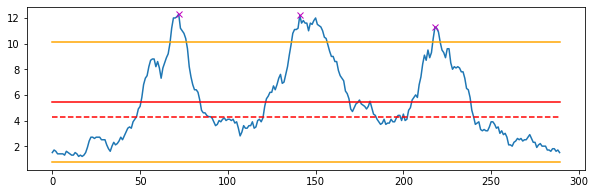

38
Peaks:  3   |  Troughs:  0


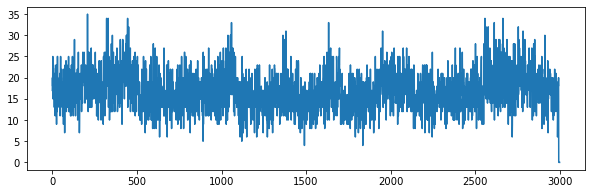

17.12457784032304   25.686866760484563


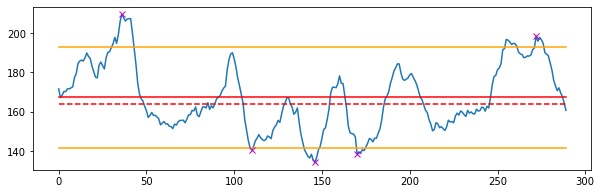

39
Peaks:  2   |  Troughs:  3


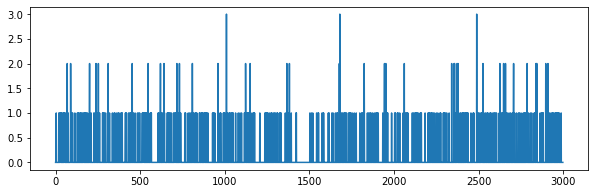

0.4899404472064471   0.7349106708096707


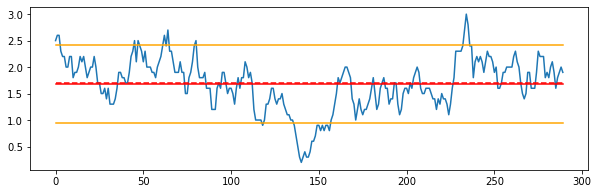

40
Peaks:  0   |  Troughs:  0


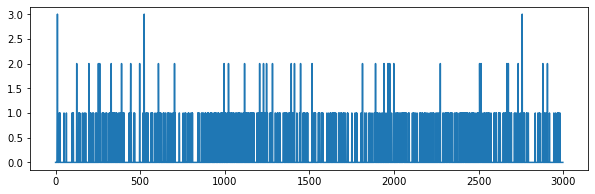

0.4222265570537293   0.6333398355805939


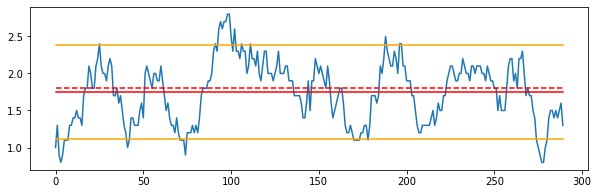

41
Peaks:  0   |  Troughs:  0


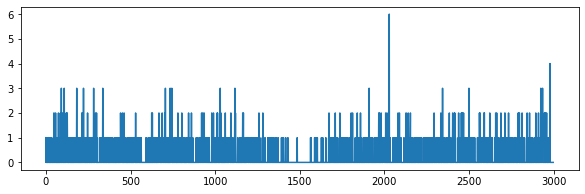

1.014079443282974   1.521119164924461


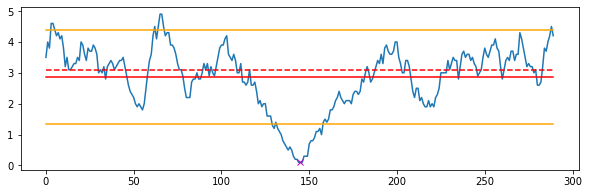

42
Peaks:  0   |  Troughs:  1


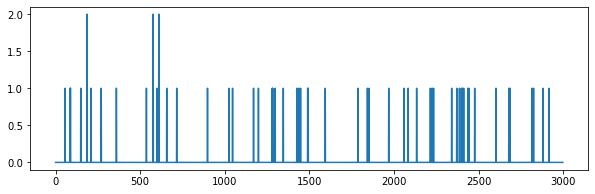

0.1536840283670049   0.23052604255050735


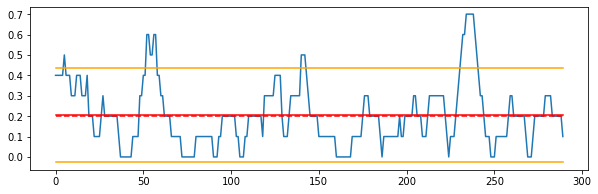

43
Peaks:  0   |  Troughs:  0


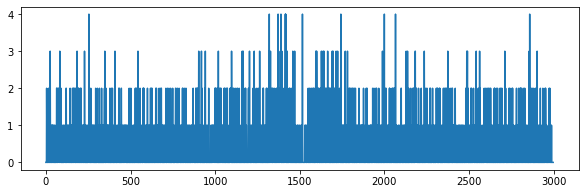

0.9165909692398337   1.3748864538597507


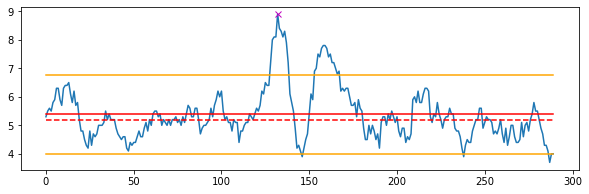

44
Peaks:  1   |  Troughs:  0


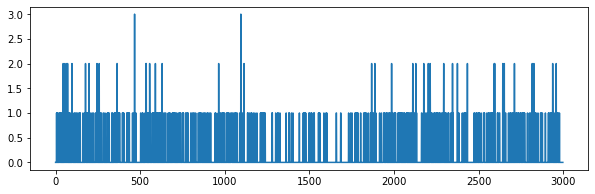

0.5874060077335684   0.8811090116003526


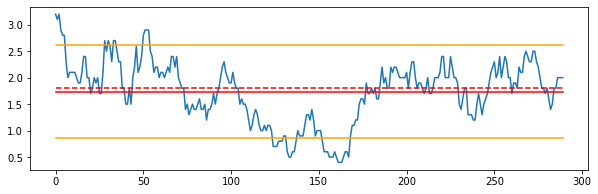

45
Peaks:  0   |  Troughs:  0


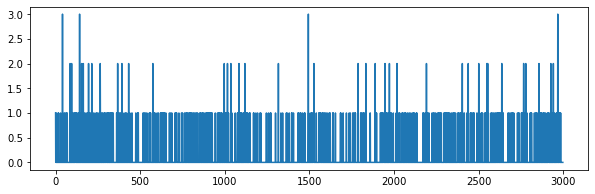

0.46242101393597895   0.6936315209039684


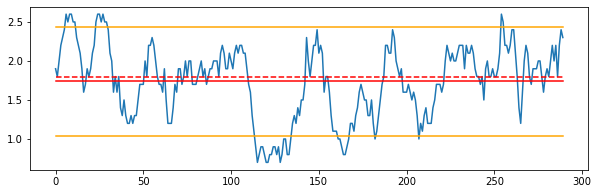

46
Peaks:  0   |  Troughs:  0


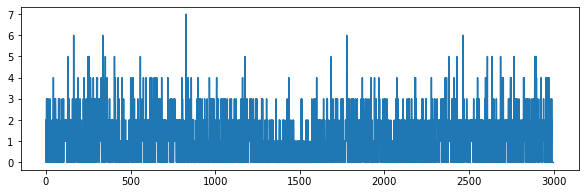

2.3004677289336035   3.4507015934004053


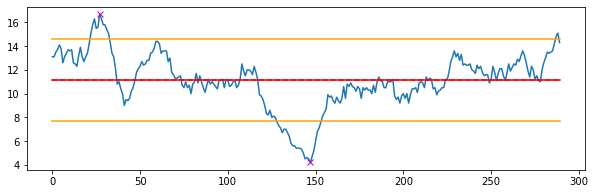

47
Peaks:  1   |  Troughs:  1


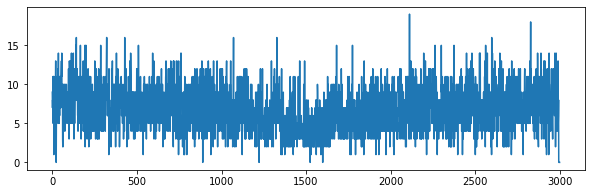

8.6071838327414   12.910775749112101


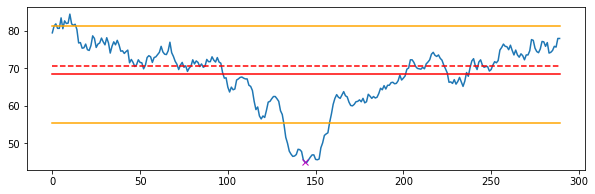

48
Peaks:  0   |  Troughs:  1


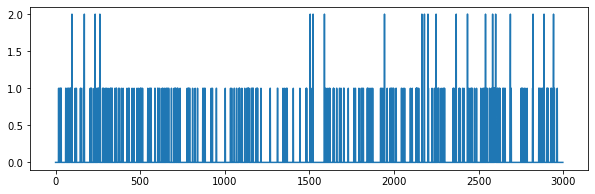

0.4182977817824565   0.6274466726736848


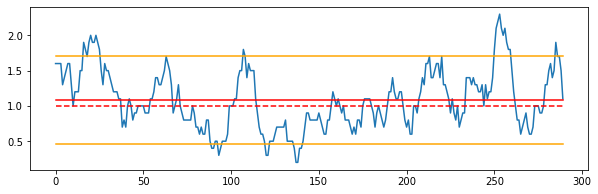

49
Peaks:  0   |  Troughs:  0


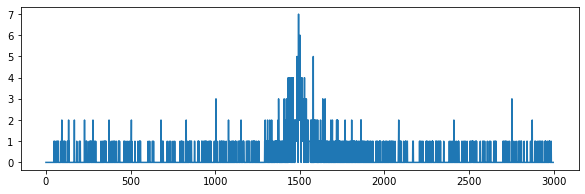

3.2120050768591946   4.818007615288792


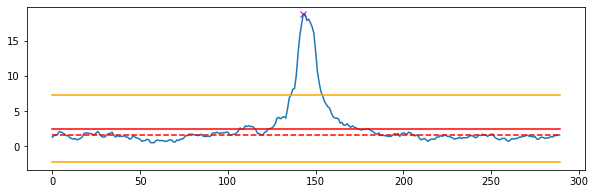

50
Peaks:  1   |  Troughs:  0


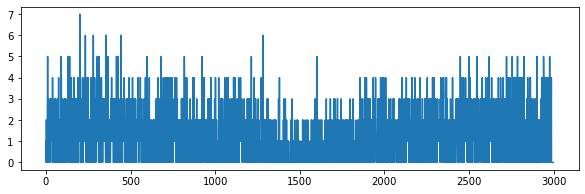

3.2427695491852355   4.8641543237778535


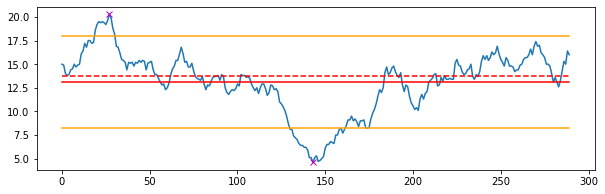

51
Peaks:  1   |  Troughs:  1


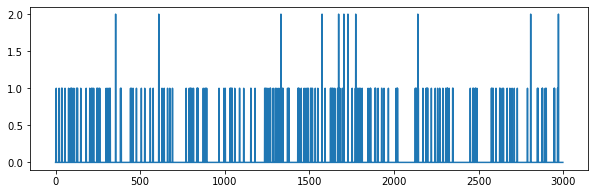

0.2740037110105192   0.4110055665157788


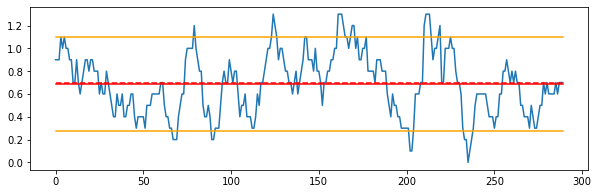

52
Peaks:  0   |  Troughs:  0


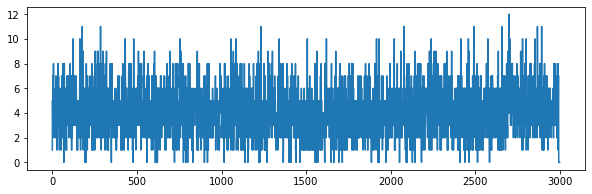

3.689540904619861   5.534311356929791


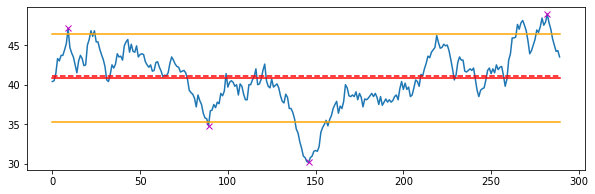

53
Peaks:  2   |  Troughs:  2


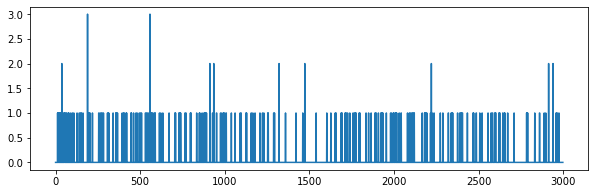

0.38580900208209123   0.5787135031231369


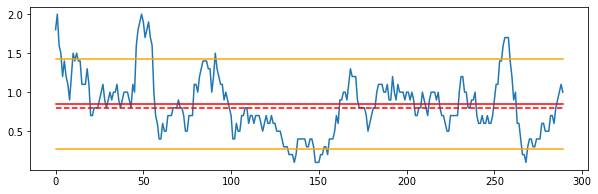

54
Peaks:  0   |  Troughs:  0


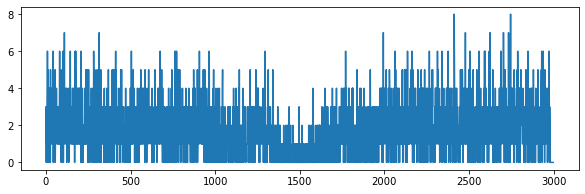

4.632060024867646   6.948090037301469


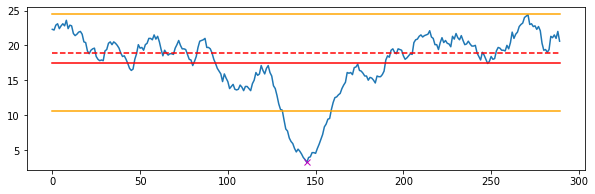

55
Peaks:  0   |  Troughs:  1


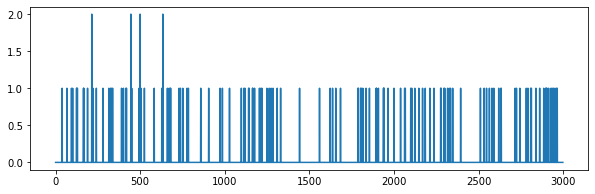

0.23407009210519883   0.35110513815779826


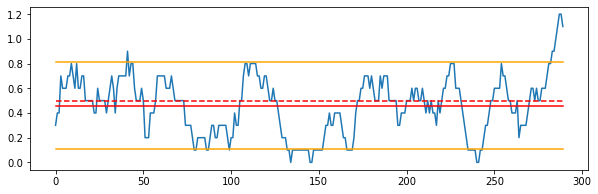

56
Peaks:  0   |  Troughs:  0


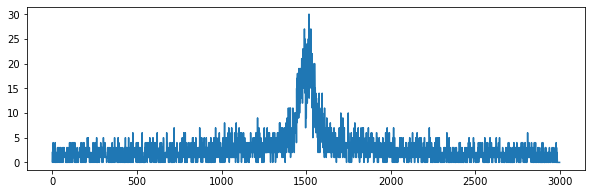

28.305014287060818   42.45752143059123


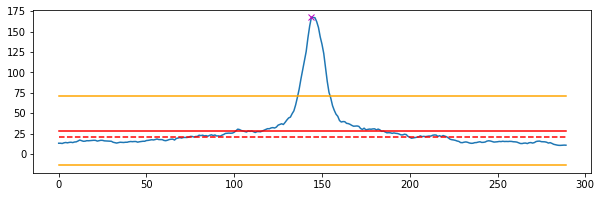

57
Peaks:  1   |  Troughs:  0


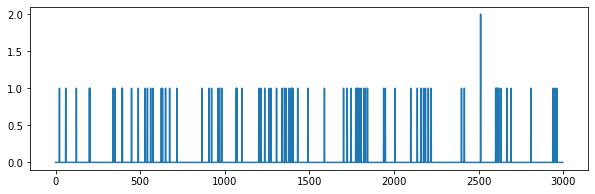

0.20170523490916778   0.30255785236375166


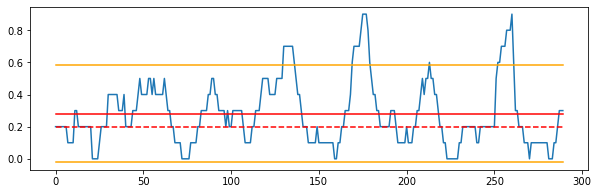

58
Peaks:  0   |  Troughs:  0


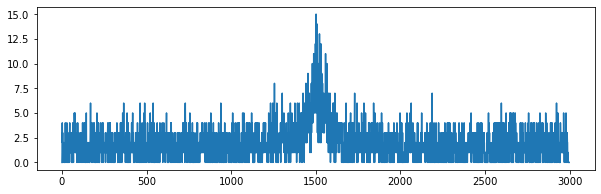

8.841750658499453   13.26262598774918


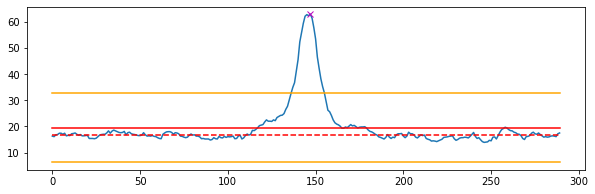

59
Peaks:  1   |  Troughs:  0


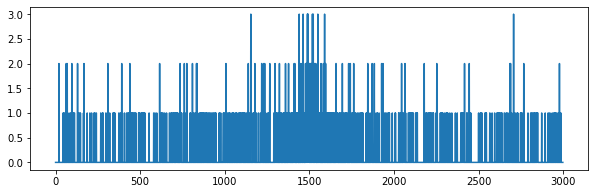

1.5510656585864286   2.326598487879643


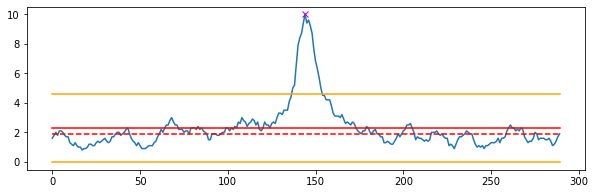

60
Peaks:  1   |  Troughs:  0


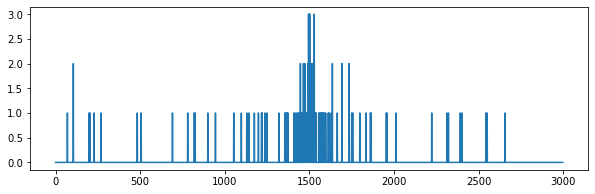

1.0400405212705606   1.560060781905841


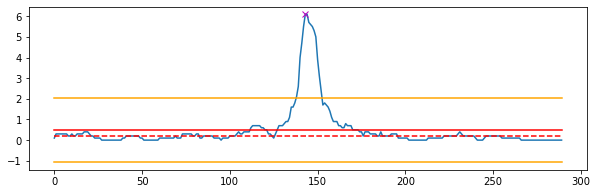

61
Peaks:  1   |  Troughs:  0


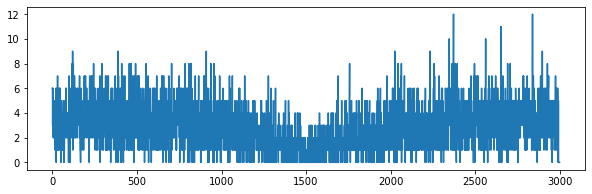

7.561495451232807   11.34224317684921


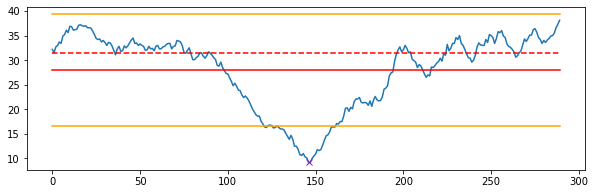

62
Peaks:  0   |  Troughs:  1


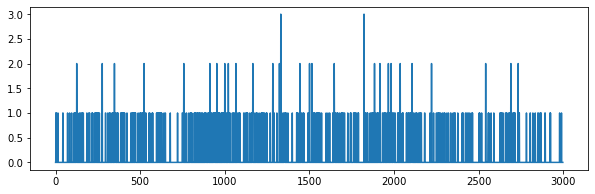

0.5784274647190396   0.8676411970785594


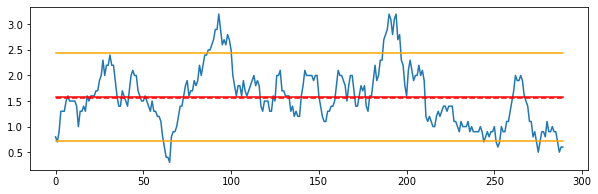

63
Peaks:  0   |  Troughs:  0


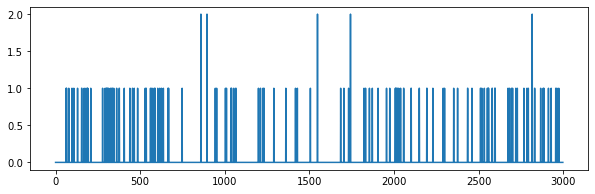

0.24762419613766873   0.3714362942065031


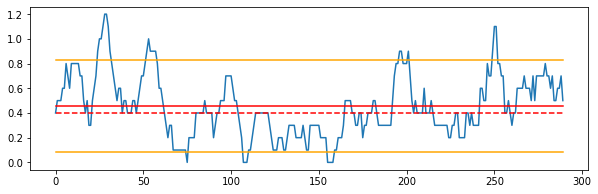

64
Peaks:  0   |  Troughs:  0


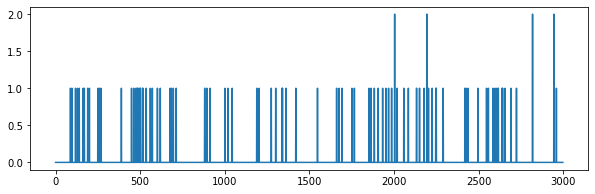

0.2353032452590647   0.3529548678885971


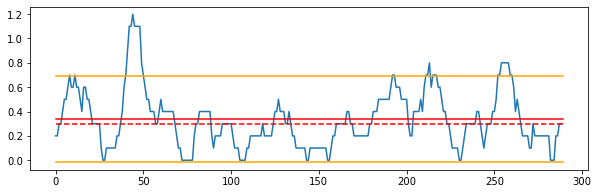

65
Peaks:  0   |  Troughs:  0


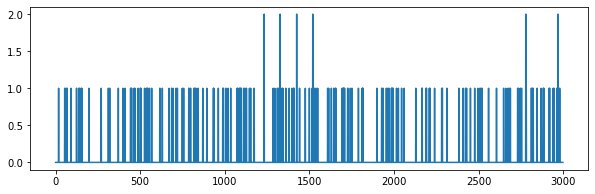

0.2496074952447879   0.37441124286718186


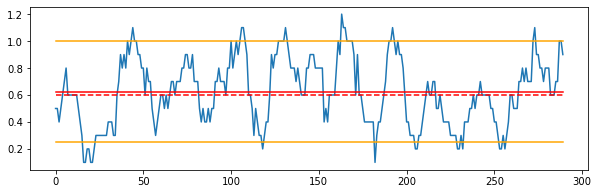

66
Peaks:  0   |  Troughs:  0


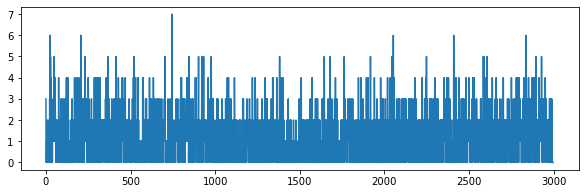

2.0275526069713976   3.0413289104570964


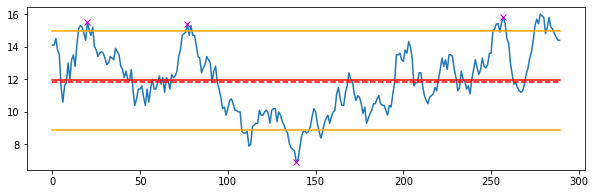

67
Peaks:  3   |  Troughs:  1


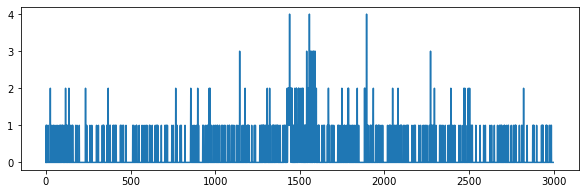

1.464315873033268   2.196473809549902


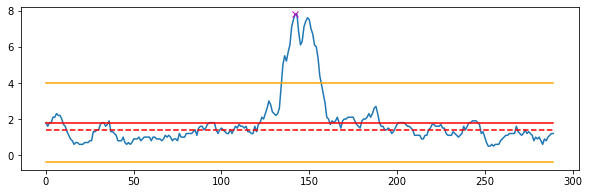

68
Peaks:  1   |  Troughs:  0


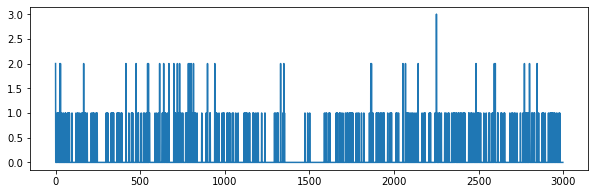

0.44447864913653756   0.6667179737048063


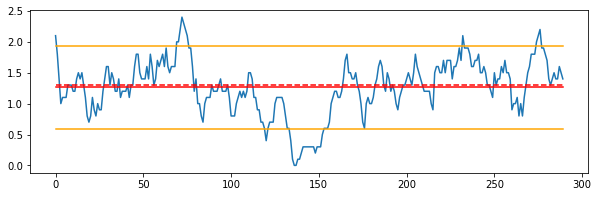

69
Peaks:  0   |  Troughs:  0


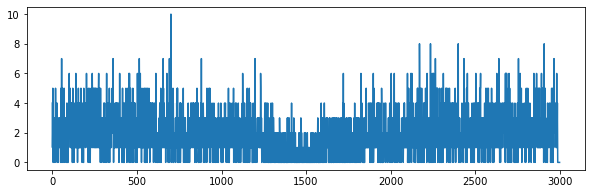

4.594456644454656   6.891684966681984


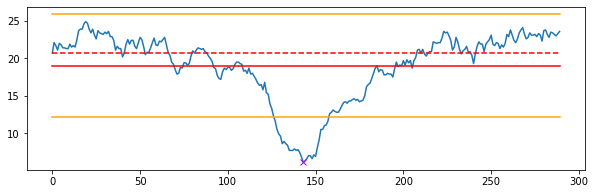

70
Peaks:  0   |  Troughs:  1


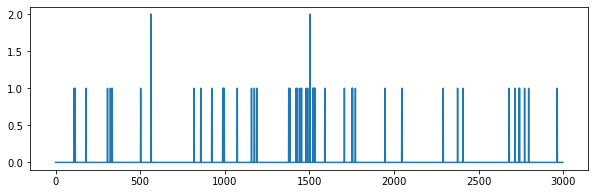

0.20826525953016886   0.3123978892952533


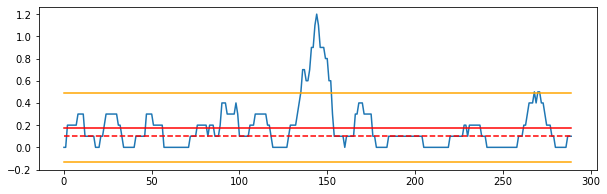

71
Peaks:  0   |  Troughs:  0


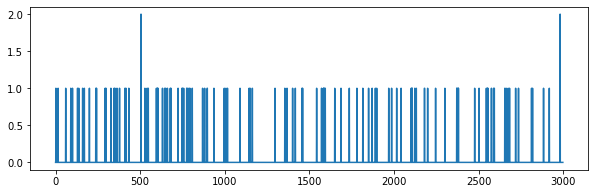

0.18838736250985214   0.2825810437647782


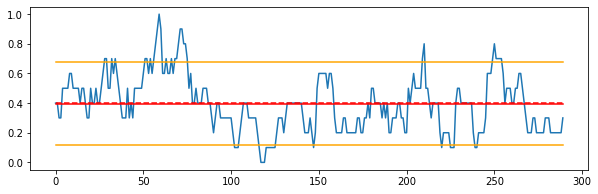

72
Peaks:  0   |  Troughs:  0


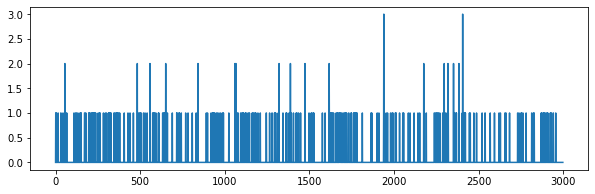

0.39266086611850315   0.5889912991777547


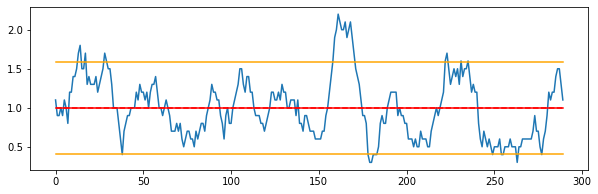

73
Peaks:  0   |  Troughs:  0


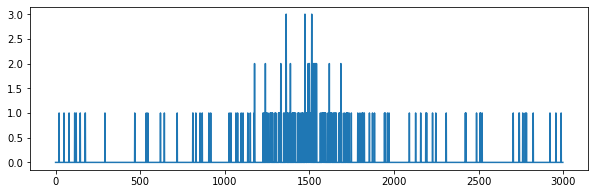

0.9815527950711522   1.4723291926067283


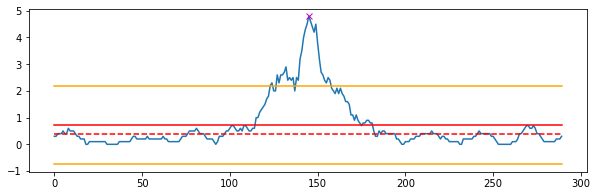

74
Peaks:  1   |  Troughs:  0


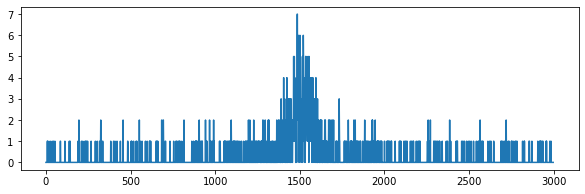

4.872637465645722   7.308956198468583


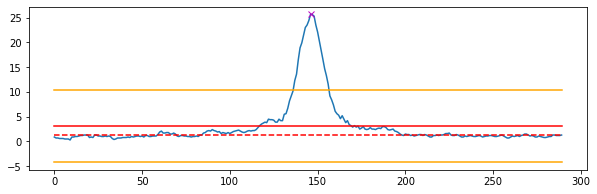

75
Peaks:  1   |  Troughs:  0


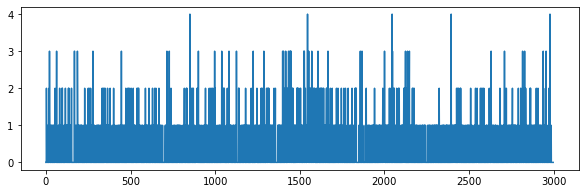

1.3210377718500617   1.9815566577750925


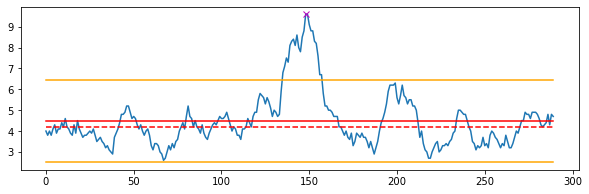

76
Peaks:  1   |  Troughs:  0


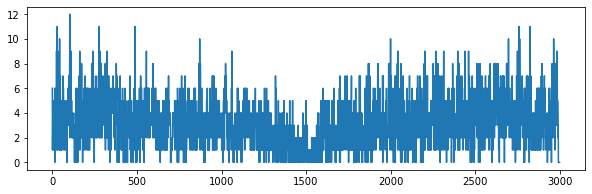

7.488272213093095   11.232408319639642


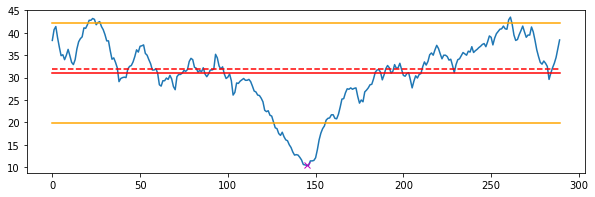

77
Peaks:  0   |  Troughs:  1


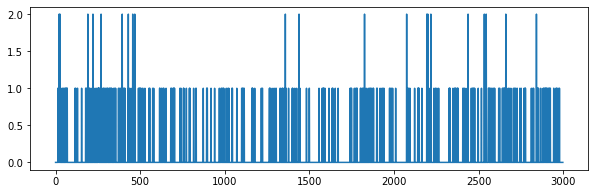

0.42870123772040175   0.6430518565806026


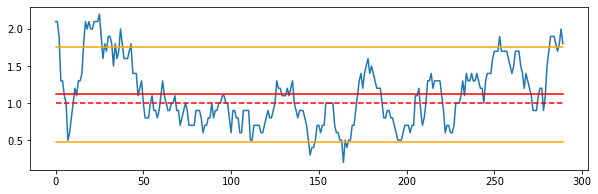

78
Peaks:  0   |  Troughs:  0


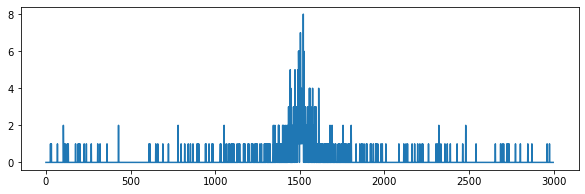

3.8640364686177304   5.796054702926596


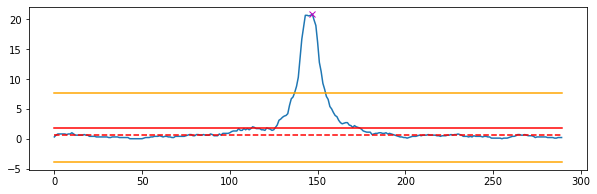

79
Peaks:  1   |  Troughs:  0


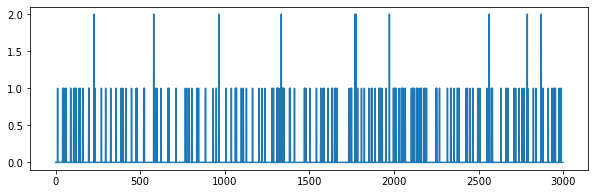

0.2400940435401665   0.36014106531024975


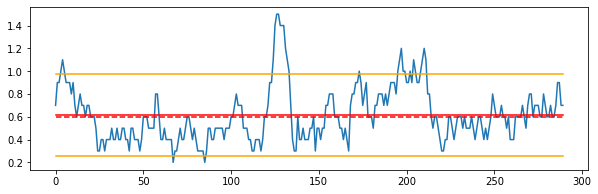

80
Peaks:  0   |  Troughs:  0


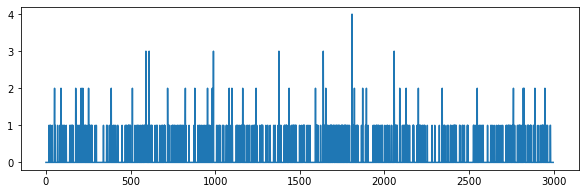

0.4540771035722298   0.6811156553583447


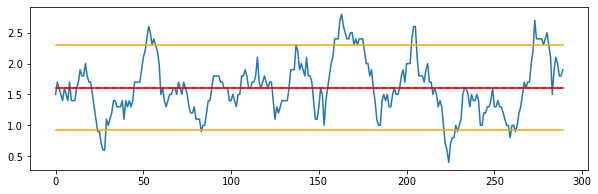

81
Peaks:  0   |  Troughs:  0


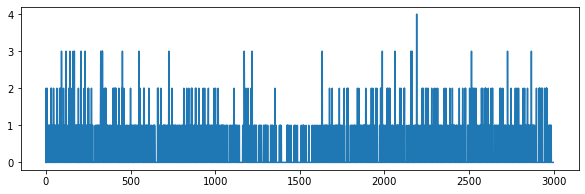

1.0307819915671423   1.5461729873507135


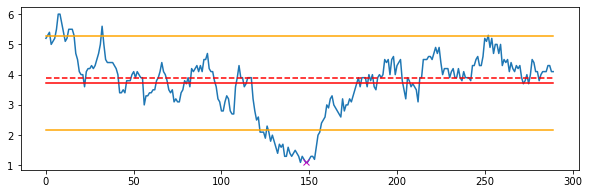

82
Peaks:  0   |  Troughs:  1


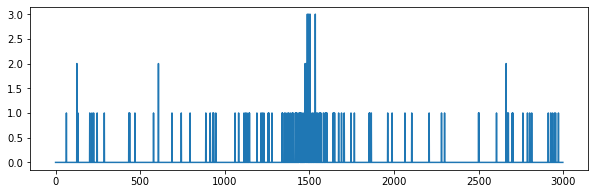

0.6815016197353788   1.0222524296030682


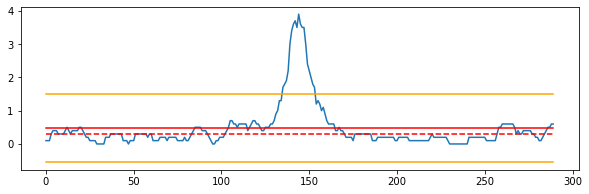

83
Peaks:  0   |  Troughs:  0


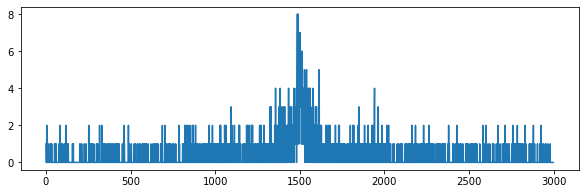

4.613314474979382   6.9199717124690725


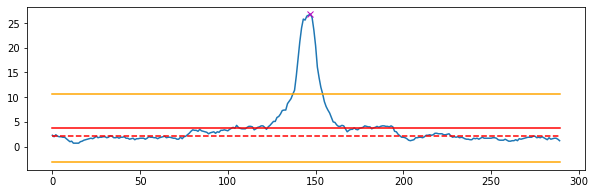

84
Peaks:  1   |  Troughs:  0


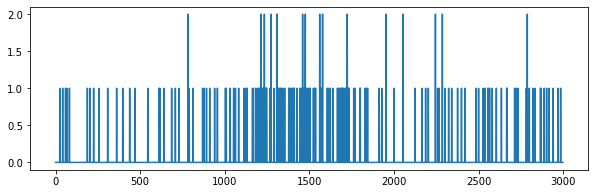

0.4678654751653389   0.7017982127480084


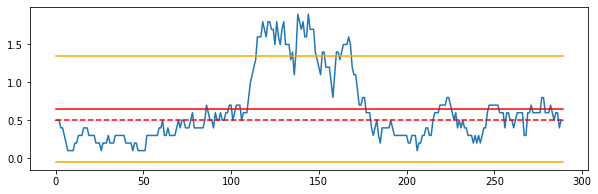

85
Peaks:  0   |  Troughs:  0


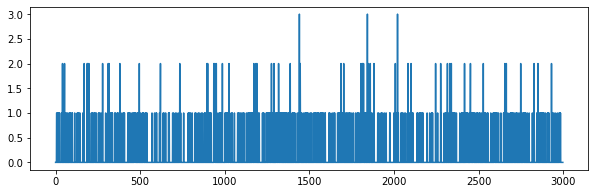

0.5762971134439654   0.8644456701659481


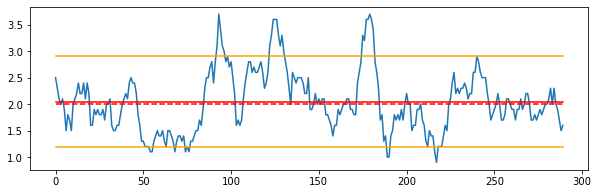

86
Peaks:  0   |  Troughs:  0


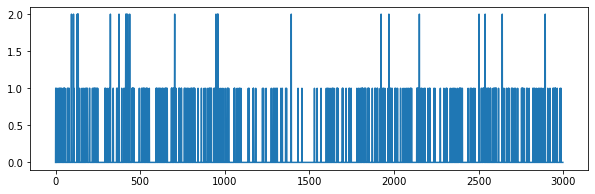

0.4729536141179877   0.7094304211769815


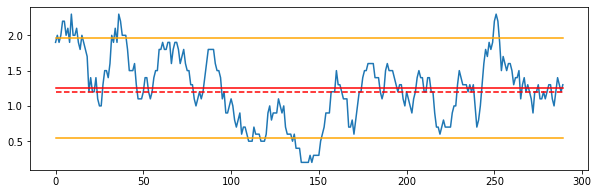

87
Peaks:  0   |  Troughs:  0


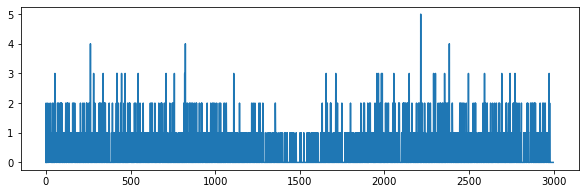

1.2114793180940686   1.817218977141103


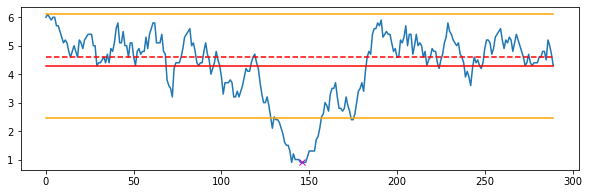

88
Peaks:  0   |  Troughs:  1


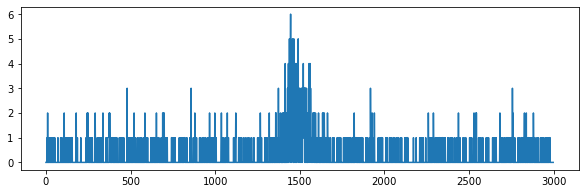

3.090663297446681   4.635994946170021


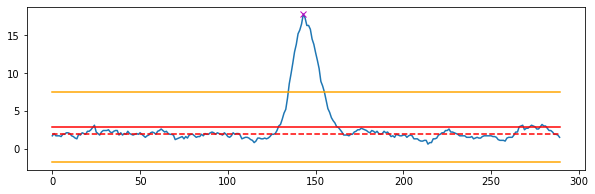

89
Peaks:  1   |  Troughs:  0


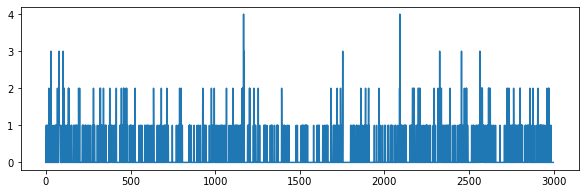

0.9829834854326583   1.4744752281489875


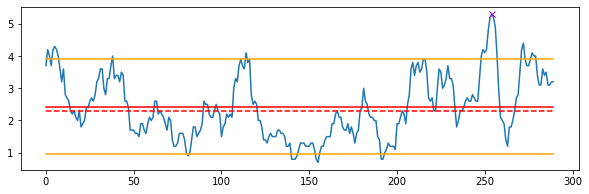

90
Peaks:  1   |  Troughs:  0


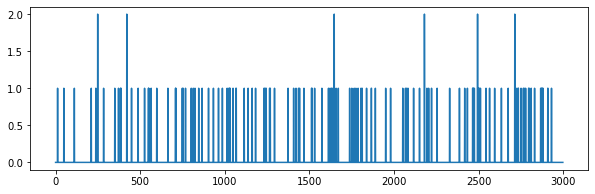

0.243502854966925   0.3652542824503875


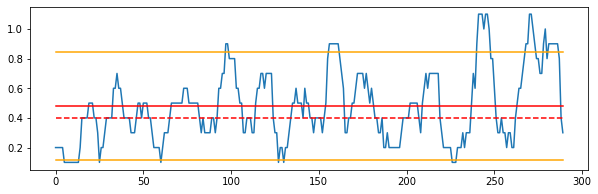

91
Peaks:  0   |  Troughs:  0


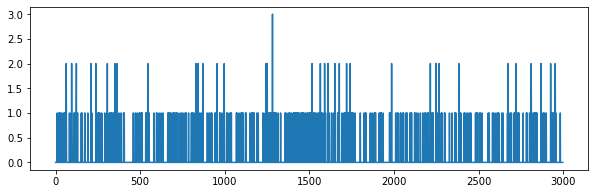

0.39247789428993857   0.5887168414349079


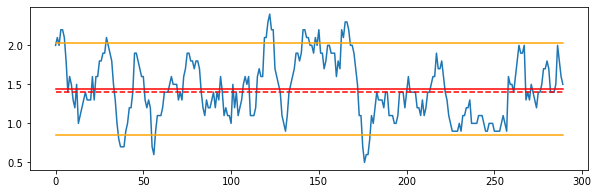

92
Peaks:  0   |  Troughs:  0


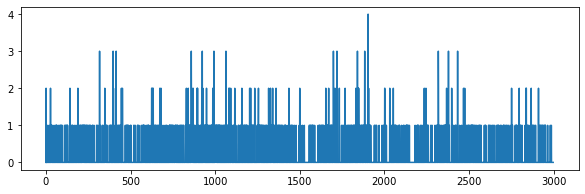

0.7583458408077237   1.1375187612115856


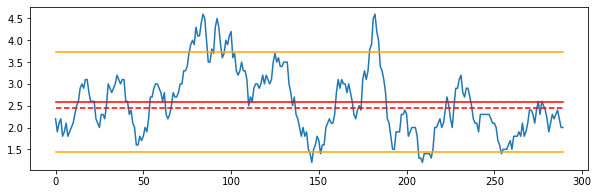

93
Peaks:  0   |  Troughs:  0


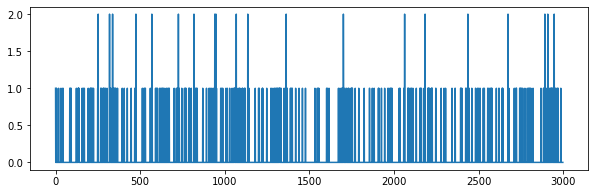

0.3694909541612837   0.5542364312419256


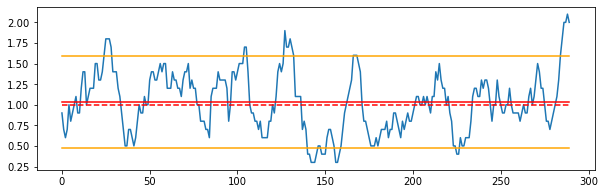

94
Peaks:  0   |  Troughs:  0


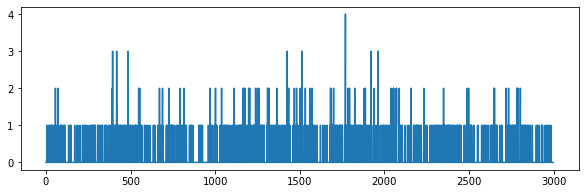

0.6982426335631048   1.0473639503446572


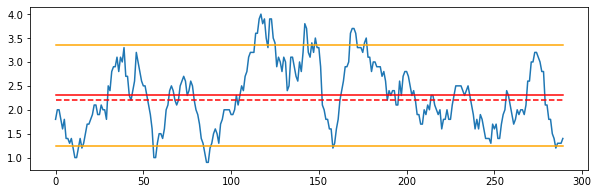

95
Peaks:  0   |  Troughs:  0


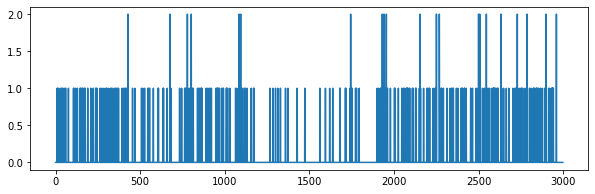

0.46879233889847577   0.7031885083477136


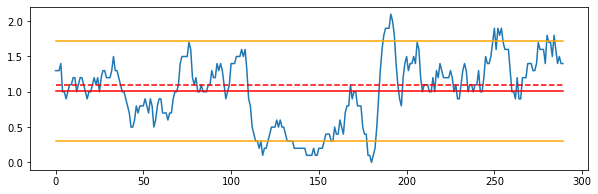

96
Peaks:  0   |  Troughs:  0


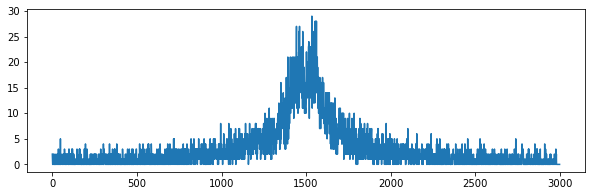

40.781310223831284   61.171965335746926


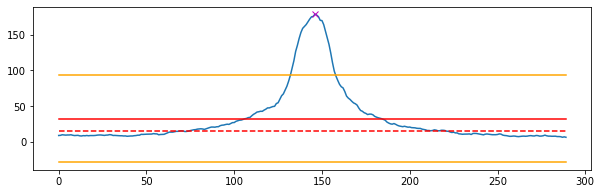

97
Peaks:  1   |  Troughs:  0


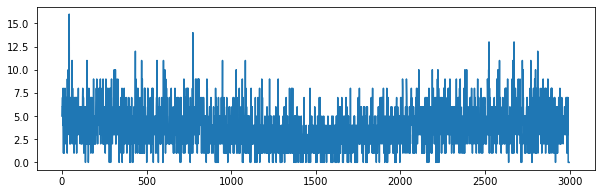

6.8797620077571775   10.319643011635765


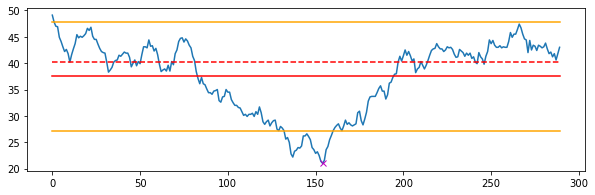

98
Peaks:  0   |  Troughs:  1


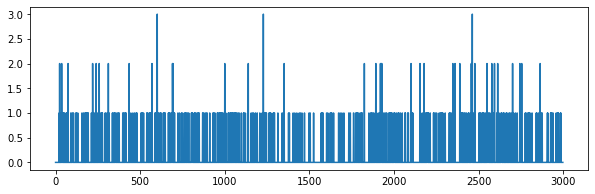

0.4833267022518545   0.7249900533777818


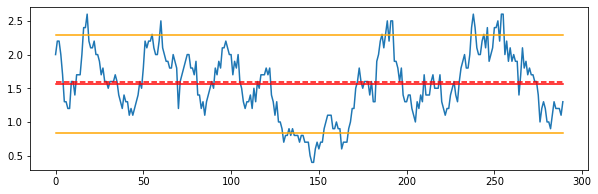

99
Peaks:  0   |  Troughs:  0


In [9]:
rowNum = 0

def findExtrema(rowNum, dataRow, peakScan, troughScan):
    plt.rcParams["figure.figsize"] = (10,3)
    plt.plot(np.array(dataRows[rowNum]))
    plt.show()
    
    peaks = []
    troughs = []
    ymax = max(dataRow)
    my = mean(dataRow)
    mdy = median(dataRow)
    sy = stdev(dataRow)
    sy15 = sy * 1.5
    sy2 = sy * 2
    y = np.array(dataRow)
    meanArr = np.array([my] * len(y))
    medianArr = np.array([mdy] * len(y))
    
    plt.rcParams["figure.figsize"] = (10,3)
    plt.plot(y);
    plt.plot(meanArr, color="red")
    plt.plot(medianArr, color="red", linestyle='dashed')
    plt.plot(meanArr + sy15, color="orange")
    plt.plot(meanArr - sy15, color="orange")
    print(sy, " ", sy15)
    #invert data before finding peaks
    if peakScan == True:
        #returns indexes of y that are detected as peaks
        peaks, _ = find_peaks(y, height=my+sy15, distance = 20, prominence=4, width=3)
        plt.plot(peaks, y[peaks], "xm");
    
    if troughScan == True:
        yinv = ymax - y
        myInv = ymax - my
        troughs, _ = find_peaks(yinv, height=myInv+sy15, distance = 20, prominence=4, width=3)
        plt.plot(troughs, y[troughs], "xm");
    
    plt.show()
    
    return len(peaks), len(troughs)
    
#find peaks in histo
def findPeaks(rowNum):
    dataRow = peakPreProc(rowNum)
    return findExtrema(rowNum, dataRow, True, False)
    
#find troughs by running the peak search algo on a inverted dataset
#uses max(y) - y
def findTroughs(rowNum):
    dataRow = peakPreProc(rowNum)
    return findExtrema(rowNum, dataRow, False, True)
    
#dynamically switch between peak/trough detection
#uses stddev outlier detection to determine if there is a substantial negative peak
#if n points are less than mean(y) - stddev(y), then the histo will be treated asna trough
def findDynamicExtrema(rowNum):
    dataRow = peakPreProc(rowNum)
    my = mean(dataRow)
    sy = stdev(dataRow)
    sy15 = sy * 1.5
    sy2 = sy * 2
    
    #generate signal array
    #square signal based on outlier status
    peakScan = False
    troughScan = False
    scanThresh = 5
    signals = []
    for i in dataRow:
        if i > (my + sy15):
            signals.append(1)
        elif i < (my - sy15):
            signals.append(-1)
        else:
            signals.append(0)
    #group by signal level and get length of continuous signal
    #[0, 0, 1, 1, 1, 0, 1, 1] => [(0,2),(1,3),(0,1),(1,2)]
    #if there is a long continous signal, then that indicates peak/trough
    grouped_L = [(k, sum(1 for i in g)) for k,g in groupby(signals)]
    for (sigVal, count) in grouped_L:
        if sigVal == 1 and count > scanThresh:
            peakScan = True
        if sigVal == -1 and count > scanThresh:
            troughScan = True
    
    return findExtrema(rowNum, dataRow, peakScan, troughScan)
    
for i in range(0, 100):
    pCount, tCount = findDynamicExtrema(i)
    print(i)
    print("Peaks: ", pCount, "  |  Troughs: ", tCount)
